In [1]:
import numpy as np
import cv2
import scipy.io
import os
from numpy.linalg import norm
from matplotlib import pyplot as plt
from numpy.linalg import det
from numpy.linalg import inv
from scipy.linalg import rq
from numpy.linalg import svd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import sys
from scipy import ndimage, spatial
from tqdm.notebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from skimage import io, transform,data
from torchvision import transforms, utils
import numpy as np
import math
import glob
import matplotlib.pyplot as plt
import time
import os
import copy
import sklearn.svm
import cv2
from matplotlib import pyplot as plt
import numpy as np
from os.path import exists
import pandas as pd
import PIL
import random
from google.colab import drive
from sklearn.metrics.cluster import completeness_score
from sklearn.cluster import KMeans
from tqdm import tqdm, tqdm_notebook
from functools import partial
from torchsummary import summary
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler
import h5py as h5

#cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
#accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#print("Accelerator type = ",accelerator)
#print("Pytorch verision: ", torch.__version__)

In [2]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!pip install ipython-autotime

#%load_ext autotime

In [3]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

In [2]:
class Image:
    def __init__(self, img, position):
        
        self.img = img
        self.position = position

inlier_matchset = []
def features_matching(a,keypointlength,threshold):
  #threshold=0.2
  bestmatch=np.empty((keypointlength),dtype= np.int16)
  img1index=np.empty((keypointlength),dtype=np.int16)
  distance=np.empty((keypointlength))
  index=0
  for j in range(0,keypointlength):
    #For a descriptor fa in Ia, take the two closest descriptors fb1 and fb2 in Ib
    x=a[j]
    listx=x.tolist()
    x.sort()
    minval1=x[0]                                # min 
    minval2=x[1]                                # 2nd min
    itemindex1 = listx.index(minval1)           #index of min val    
    itemindex2 = listx.index(minval2)           #index of second min value 
    ratio=minval1/minval2                       #Ratio Test
    
    if ratio<threshold: 
      #Low distance ratio: fb1 can be a good match
      bestmatch[index]=itemindex1
      distance[index]=minval1
      img1index[index]=j
      index=index+1
  return  [cv2.DMatch(img1index[i],bestmatch[i].astype(int),distance[i]) for i in range(0,index)]
          
   
  
def compute_Homography(im1_pts,im2_pts):
  """
  im1_pts and im2_pts are 2×n matrices with
  4 point correspondences from the two images
  """
  num_matches=len(im1_pts)
  num_rows = 2 * num_matches
  num_cols = 9
  A_matrix_shape = (num_rows,num_cols)
  A = np.zeros(A_matrix_shape)
  a_index = 0
  for i in range(0,num_matches):
    (a_x, a_y) = im1_pts[i]
    (b_x, b_y) = im2_pts[i]
    row1 = [a_x, a_y, 1, 0, 0, 0, -b_x*a_x, -b_x*a_y, -b_x] # First row 
    row2 = [0, 0, 0, a_x, a_y, 1, -b_y*a_x, -b_y*a_y, -b_y] # Second row 

    # place the rows in the matrix
    A[a_index] = row1
    A[a_index+1] = row2

    a_index += 2
    
  U, s, Vt = np.linalg.svd(A)

  #s is a 1-D array of singular values sorted in descending order
  #U, Vt are unitary matrices
  #Rows of Vt are the eigenvectors of A^TA.
  #Columns of U are the eigenvectors of AA^T.
  H = np.eye(3)
  H = Vt[-1].reshape(3,3) # take the last row of the Vt matrix
  return H
  
  
def displayplot(img,title):
  
  plt.figure(figsize=(15,15))
  plt.title(title)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.show()

In [3]:
def get_inliers(f1, f2, matches, H, RANSACthresh):

  inlier_indices = []
  for i in range(len(matches)):
    queryInd = matches[i].queryIdx
    trainInd = matches[i].trainIdx

    #queryInd = matches[i][0]
    #trainInd = matches[i][1]

    queryPoint = np.array([f1[queryInd].pt[0],  f1[queryInd].pt[1], 1]).T 
    trans_query = H.dot(queryPoint) 

   
    comp1 = [trans_query[0]/trans_query[2], trans_query[1]/trans_query[2]] # normalize with respect to z
    comp2 = np.array(f2[trainInd].pt)[:2]
    

    if(np.linalg.norm(comp1-comp2) <= RANSACthresh): # check against threshold
      inlier_indices.append(i)
  return inlier_indices


def RANSAC_alg(f1, f2, matches, nRANSAC, RANSACthresh):

      
    minMatches = 4
    nBest = 0
    best_inliers = []
    H_estimate = np.eye(3,3)
    global inlier_matchset
    inlier_matchset=[]
    for iteration in range(nRANSAC):
      
        #Choose a minimal set of feature matches.
        matchSample = random.sample(matches, minMatches)
        
        #Estimate the Homography implied by these matches
        im1_pts=np.empty((minMatches,2))
        im2_pts=np.empty((minMatches,2))
        for i in range(0,minMatches):
          m = matchSample[i]
          im1_pts[i] = f1[m.queryIdx].pt
          im2_pts[i] = f2[m.trainIdx].pt
          #im1_pts[i] = f1[m[0]].pt
          #im2_pts[i] = f2[m[1]].pt             
          
        H_estimate=compute_Homography(im1_pts,im2_pts)
        
               
        # Calculate the inliers for the H
        inliers = get_inliers(f1, f2, matches, H_estimate, RANSACthresh)

        # if the number of inliers is higher than previous iterations, update the best estimates
        if len(inliers) > nBest:
            nBest= len(inliers)
            best_inliers = inliers

    print("Number of best inliers",len(best_inliers))
    for i in range(len(best_inliers)):
      inlier_matchset.append(matches[best_inliers[i]])
    
    # compute a homography given this set of matches
    im1_pts=np.empty((len(best_inliers),2))
    im2_pts=np.empty((len(best_inliers),2))
    for i in range(0,len(best_inliers)):
      m = inlier_matchset[i]
      im1_pts[i] = f1[m.queryIdx].pt
      im2_pts[i] = f2[m.trainIdx].pt
      #im1_pts[i] = f1[m[0]].pt
      #im2_pts[i] = f2[m[1]].pt

    M=compute_Homography(im1_pts,im2_pts)
    return M, best_inliers

In [4]:
tqdm = partial(tqdm, position=0, leave=True)

In [5]:
files_all=[]
for file in os.listdir("/content/drive/MyDrive/MAP-20210707T092105Z-001/MAP"):
    if file.endswith(".JPG"):
      files_all.append(file)


files_all.sort()
folder_path = '/content/drive/MyDrive/MAP-20210707T092105Z-001/MAP/'

#centre_file = folder_path + files_all[50]
left_files_path_rev = []
right_files_path = []


#Change this according to your dataset split

for file in files_all[:31]:
  left_files_path_rev.append(folder_path + file)

left_files_path = left_files_path_rev[::-1]

for file in files_all[30:60]:
  right_files_path.append(folder_path + file)

In [6]:
print(len(files_all))

176


In [7]:
from multiprocessing import Pool

In [8]:
import multiprocessing
print(multiprocessing.cpu_count())


2


In [9]:
gridsize = 8
clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(gridsize,gridsize))

images_left_bgr = []
images_right_bgr = []

images_left = []
images_right = []

for file in tqdm(left_files_path):
  left_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(left_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  left_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  left_img = cv2.resize(left_image_sat,None,fx=0.75, fy=0.75, interpolation = cv2.INTER_CUBIC )
  #images_left.append(cv2.cvtColor(left_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_left_bgr.append(left_img)


for file in tqdm(right_files_path):
  right_image_sat= cv2.imread(file)
  lab = cv2.cvtColor(right_image_sat, cv2.COLOR_BGR2LAB)
  lab[...,0] = clahe.apply(lab[...,0])
  right_image_sat = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  right_img = cv2.resize(right_image_sat,None,fx=0.75,fy=0.75, interpolation = cv2.INTER_CUBIC )
  #images_right.append(cv2.cvtColor(right_img, cv2.COLOR_BGR2GRAY).astype('float32')/255.)
  images_right_bgr.append(right_img)

100%|██████████| 30/30 [00:32<00:00,  1.07s/it]


In [10]:
Dataset = 'MAP Dataset'

In [11]:

f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left_bgr + images_right_bgr)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize(f'drive/MyDrive/all_images_bgr_{Dataset}.h5')/1.e6,'MB')

HDF5  w/o comp.: 25.915335416793823 [s] ... size 2054.8256 MB


In [ ]:
'''
f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','w')
t0=time.time()
f.create_dataset('data',data=images_left + images_right)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize(f'drive/MyDrive/all_images_gray_{Dataset}.h5')/1.e6,'MB')
'''

In [12]:
del images_left_bgr,images_right_bgr

In [ ]:
#images_left_bgr_no_enhance = []
#images_right_bgr_no_enhance = []

#for file in tqdm(left_files_path):
#  left_image_sat= cv2.imread(file)
#  left_img = cv2.resize(left_image_sat,None,fx=0.35, fy=0.35, interpolation = cv2.INTER_CUBIC)
#  images_left_bgr_no_enhance.append(left_img)

#for file in tqdm(right_files_path):
# right_image_sat= cv2.imread(file)
#  right_img = cv2.resize(right_image_sat,None,fx=0.35,fy=0.35, interpolation = cv2.INTER_CUBIC)
#  images_right_bgr_no_enhance.append(right_img)

In [13]:
from timeit import default_timer as timer

In [14]:
time_all = []

In [15]:
num_kps_sift = []
num_kps_brisk = []
num_kps_agast = []
num_kps_kaze = []
num_kps_akaze = []
num_kps_orb = []
num_kps_mser = []
num_kps_daisy = []
num_kps_surfsift = []
num_kps_fast = []
num_kps_freak = []
num_kps_gftt = []
num_kps_star = []
num_kps_surf = []
num_kps_rootsift = []
num_kps_superpoint = []


In [ ]:
images_left_bgr=[]
images_right_bgr=[]

BRISK

In [16]:

Threshl=60;
Octaves=6; 
#PatternScales=1.0f;

start = timer()

brisk = cv2.BRISK_create(Threshl,Octaves)


keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk=[]

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_left_brisk.append(kpt)
  descriptors_all_left_brisk.append(descrip)
  points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  brisk.compute(imgs, kpt)
  keypoints_all_right_brisk.append(kpt)
  descriptors_all_right_brisk.append(descrip)
  points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 30/30 [02:56<00:00,  5.88s/it]


In [17]:

for j in tqdm(keypoints_all_left_brisk + keypoints_all_right_brisk[1:]):
  num_kps_brisk.append(len(j))

100%|██████████| 60/60 [00:00<00:00, 9320.33it/s]


In [ ]:
'''
all_feat_brisk_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_brisk):
  all_feat_brisk_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_brisk[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_brisk_left_each.append(temp)
  all_feat_brisk_left.append(all_feat_brisk_left_each)

In [ ]:
'''
all_feat_brisk_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_brisk):
  all_feat_brisk_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_brisk[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_brisk_right_each.append(temp)
  all_feat_brisk_right.append(all_feat_brisk_right_each)

In [ ]:
'''
del keypoints_all_left_brisk, keypoints_all_right_brisk, descriptors_all_left_brisk, descriptors_all_right_brisk

In [ ]:
'''
import pickle
Fdb = open('all_feat_brisk_left.dat', 'wb')
pickle.dump(all_feat_brisk_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_brisk_right.dat', 'wb')
pickle.dump(all_feat_brisk_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_brisk_left, all_feat_brisk_right

ORB

In [18]:

orb = cv2.ORB_create(20000)

start = timer()


keypoints_all_left_orb = []
descriptors_all_left_orb = []
points_all_left_orb=[]

keypoints_all_right_orb = []
descriptors_all_right_orb = []
points_all_right_orb=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()    
  kpt = orb.detect(imgs,None)
  kpt,descrip =  orb.compute(imgs, kpt)
  keypoints_all_left_orb.append(kpt)
  descriptors_all_left_orb.append(descrip)
  #points_all_left_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = orb.detect(imgs,None)
  kpt,descrip =  orb.compute(imgs, kpt)
  keypoints_all_right_orb.append(kpt)
  descriptors_all_right_orb.append(descrip)
  #points_all_right_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 30/30 [00:27<00:00,  1.11it/s]


In [19]:

for j in tqdm(keypoints_all_left_orb + keypoints_all_right_orb[1:]):
  num_kps_orb.append(len(j))

100%|██████████| 60/60 [00:00<00:00, 99824.77it/s]


In [ ]:
'''
all_feat_orb_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_orb):
  all_feat_orb_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_orb[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_orb_left_each.append(temp)
  all_feat_orb_left.append(all_feat_orb_left_each)

In [ ]:
'''
all_feat_orb_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_orb):
  all_feat_orb_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_orb[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_orb_right_each.append(temp)
  all_feat_orb_right.append(all_feat_orb_right_each)

In [ ]:
'''
del keypoints_all_left_orb, keypoints_all_right_orb, descriptors_all_left_orb, descriptors_all_right_orb

In [ ]:
'''
import pickle
Fdb = open('all_feat_orb_left.dat', 'wb')
pickle.dump(all_feat_orb_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_orb_right.dat', 'wb')
pickle.dump(all_feat_orb_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_orb_left, all_feat_orb_right

KAZE


In [ ]:
'''
start = timer()

kaze = cv2.KAZE_create()


keypoints_all_left_kaze = []
descriptors_all_left_kaze = []
points_all_left_kaze=[]

keypoints_all_right_kaze = []
descriptors_all_right_kaze = []
points_all_right_kaze=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = kaze.detect(imgs,None)
  kpt,descrip =  kaze.compute(imgs, kpt)
  keypoints_all_left_kaze.append(kpt)
  descriptors_all_left_kaze.append(descrip)
  #points_all_left_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = kaze.detect(imgs,None)
  kpt,descrip =  kaze.compute(imgs, kpt)
  keypoints_all_right_kaze.append(kpt)
  descriptors_all_right_kaze.append(descrip)
  #points_all_right_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_kaze + keypoints_all_right_kaze[1:]):
  num_kps_kaze.append(len(j))

In [ ]:
'''
all_feat_kaze_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_kaze):
  all_feat_kaze_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_kaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_kaze_left_each.append(temp)
  all_feat_kaze_left.append(all_feat_kaze_left_each)

In [ ]:
'''
all_feat_kaze_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_kaze):
  all_feat_kaze_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_kaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_kaze_right_each.append(temp)
  all_feat_kaze_right.append(all_feat_kaze_right_each)

In [ ]:
'''
del keypoints_all_left_kaze, keypoints_all_right_kaze, descriptors_all_left_kaze, descriptors_all_right_kaze

In [ ]:
'''
import pickle
Fdb = open('all_feat_kaze_left.dat', 'wb')
pickle.dump(all_feat_kaze_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_kaze_right.dat', 'wb')
pickle.dump(all_feat_kaze_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_kaze_left, all_feat_kaze_right

AKAZE

In [129]:
'''
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

In [ ]:
'''
start = timer()

akaze = cv2.AKAZE_create()


keypoints_all_left_akaze = []
descriptors_all_left_akaze = []
points_all_left_akaze=[]

keypoints_all_right_akaze = []
descriptors_all_right_akaze = []
points_all_right_akaze=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = akaze.detect(imgs,None)
  kpt,descrip =  akaze.compute(imgs, kpt)
  keypoints_all_left_akaze.append(kpt)
  descriptors_all_left_akaze.append(descrip)
  #points_all_left_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = akaze.detect(imgs,None)
  kpt,descrip = akaze.compute(imgs, kpt)
  keypoints_all_right_akaze.append(kpt)
  descriptors_all_right_akaze.append(descrip)
  #points_all_right_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_akaze + keypoints_all_right_akaze[1:]):
  num_kps_akaze.append(len(j))

In [ ]:
'''
all_feat_akaze_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_akaze):
  all_feat_akaze_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_akaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_akaze_left_each.append(temp)
  all_feat_akaze_left.append(all_feat_akaze_left_each)

In [ ]:
'''
all_feat_akaze_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_akaze):
  all_feat_akaze_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_akaze[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_akaze_right_each.append(temp)
  all_feat_akaze_right.append(all_feat_akaze_right_each)

In [ ]:
'''
del keypoints_all_left_akaze, keypoints_all_right_akaze, descriptors_all_left_akaze, descriptors_all_right_akaze

In [ ]:
'''
import pickle
Fdb = open('all_feat_akaze_left.dat', 'wb')
pickle.dump(all_feat_akaze_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_akaze_right.dat', 'wb')
pickle.dump(all_feat_akaze_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_akaze_left, all_feat_akaze_right


STAR + BRIEF

In [20]:

start = timer()

star = cv2.xfeatures2d.StarDetector_create()
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()

keypoints_all_left_star = []
descriptors_all_left_brief = []
points_all_left_star=[]

keypoints_all_right_star = []
descriptors_all_right_brief = []
points_all_right_star=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = star.detect(imgs,None)
  kpt,descrip =  brief.compute(imgs, kpt)
  keypoints_all_left_star.append(kpt)
  descriptors_all_left_brief.append(descrip)
  #points_all_left_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = star.detect(imgs,None)
  kpt,descrip =  brief.compute(imgs, kpt)
  keypoints_all_right_star.append(kpt)
  descriptors_all_right_brief.append(descrip)
  #points_all_right_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 30/30 [01:38<00:00,  3.28s/it]


In [21]:

for j in tqdm(keypoints_all_left_star + keypoints_all_right_star[1:]):
  num_kps_star.append(len(j))

100%|██████████| 60/60 [00:00<00:00, 6910.46it/s]


In [ ]:
'''
all_feat_star_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_star):
  all_feat_star_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_brief[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_star_left_each.append(temp)
  all_feat_star_left.append(all_feat_star_left_each)

In [ ]:
'''
all_feat_star_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_star):
  all_feat_star_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_brief[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_star_right_each.append(temp)
  all_feat_star_right.append(all_feat_star_right_each)

In [ ]:
'''
del keypoints_all_left_star, keypoints_all_right_star, descriptors_all_left_brief, descriptors_all_right_brief

In [ ]:
'''
import pickle
Fdb = open('all_feat_star_left.dat', 'wb')
pickle.dump(all_feat_star_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_star_right.dat', 'wb')
pickle.dump(all_feat_star_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_star_left, all_feat_star_right


BRISK + FREAK

In [22]:

start = timer()

Threshl=60;
Octaves=8; 
#PatternScales=1.0f;
brisk = cv2.BRISK_create(Threshl,Octaves)

freak = cv2.xfeatures2d.FREAK_create()
keypoints_all_left_freak = []
descriptors_all_left_freak = []
points_all_left_freak=[]

keypoints_all_right_freak = []
descriptors_all_right_freak = []
points_all_right_freak=[]


for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = brisk.detect(imgs)
  kpt,descrip =  freak.compute(imgs, kpt)
  keypoints_all_left_freak.append(kpt)
  descriptors_all_left_freak.append(descrip)
  #points_all_left_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = brisk.detect(imgs,None)
  kpt,descrip =  freak.compute(imgs, kpt)
  keypoints_all_right_freak.append(kpt)
  descriptors_all_right_freak.append(descrip)
  #points_all_right_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

100%|██████████| 30/30 [02:51<00:00,  5.72s/it]


In [23]:

for j in tqdm(keypoints_all_left_freak + keypoints_all_right_freak[1:]):
  num_kps_freak.append(len(j))

100%|██████████| 60/60 [00:00<00:00, 204933.42it/s]


In [ ]:
'''
all_feat_freak_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_freak):
  all_feat_freak_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_freak[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_freak_left_each.append(temp)
  all_feat_freak_left.append(all_feat_freak_left_each)

In [ ]:
'''
all_feat_freak_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_freak):
  all_feat_freak_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_freak[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_freak_right_each.append(temp)
  all_feat_freak_right.append(all_feat_freak_right_each)

In [ ]:
'''
del keypoints_all_left_freak, keypoints_all_right_freak, descriptors_all_left_freak, descriptors_all_right_freak

In [ ]:
'''
import pickle
Fdb = open('all_feat_freak_left.dat', 'wb')
pickle.dump(all_feat_freak_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_freak_right.dat', 'wb')
pickle.dump(all_feat_freak_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_freak_left, all_feat_freak_right

MSER + SIFT

In [ ]:
'''
start = timer()

mser = cv2.MSER_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_mser = []
descriptors_all_left_mser = []
points_all_left_mser=[]

keypoints_all_right_mser = []
descriptors_all_right_mser = []
points_all_right_mser=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = mser.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_mser.append(kpt)
  descriptors_all_left_mser.append(descrip)
  #points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = mser.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_mser.append(kpt)
  descriptors_all_right_mser.append(descrip)
  #points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_mser + keypoints_all_right_mser[1:]):
  num_kps_mser.append(len(j))

In [ ]:
'''
all_feat_mser_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_mser):
  all_feat_mser_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_mser[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_mser_left_each.append(temp)
  all_feat_mser_left.append(all_feat_mser_left_each)

In [ ]:
'''
all_feat_mser_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_mser):
  all_feat_mser_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_mser[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_mser_right_each.append(temp)
  all_feat_mser_right.append(all_feat_mser_right_each)

In [ ]:
'''
del keypoints_all_left_mser, keypoints_all_right_mser, descriptors_all_left_mser, descriptors_all_right_mser

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_left.dat', 'wb')
pickle.dump(all_feat_mser_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_right.dat', 'wb')
pickle.dump(all_feat_mser_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_mser_left, all_feat_mser_right

AGAST + SIFT

In [ ]:
'''
start = timer()

agast = cv2.AgastFeatureDetector_create(threshold = 40)
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_agast = []
descriptors_all_left_agast = []
points_all_left_agast=[]

keypoints_all_right_agast = []
descriptors_all_right_agast = []
points_all_right_agast=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = agast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_agast.append(kpt)
  descriptors_all_left_agast.append(descrip)
  #points_all_left_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = agast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_agast.append(kpt)
  descriptors_all_right_agast.append(descrip)
  #points_all_right_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_agast + keypoints_all_right_agast[1:]):
  num_kps_agast.append(len(j))

In [ ]:
'''
all_feat_agast_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_agast):
  all_feat_agast_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_agast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_agast_left_each.append(temp)
  all_feat_agast_left.append(all_feat_agast_left_each)

In [ ]:
'''
all_feat_agast_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_agast):
  all_feat_agast_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_agast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_agast_right_each.append(temp)
  all_feat_agast_right.append(all_feat_agast_right_each)

In [ ]:
'''
del keypoints_all_left_agast, keypoints_all_right_agast, descriptors_all_left_agast, descriptors_all_right_agast

In [ ]:
'''
import pickle
Fdb = open('all_feat_agast_left.dat', 'wb')
pickle.dump(all_feat_agast_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_agast_left

In [ ]:
'''
import pickle
Fdb = open('all_feat_agast_right.dat', 'wb')
pickle.dump(all_feat_agast_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_agast_right

FAST + SIFT

In [ ]:
'''
start = timer()


fast = cv2.FastFeatureDetector_create(threshold=40)
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_fast = []
descriptors_all_left_fast = []
points_all_left_fast=[]

keypoints_all_right_fast = []
descriptors_all_right_fast = []
points_all_right_fast=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = fast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_fast.append(kpt)
  descriptors_all_left_fast.append(descrip)
  #points_all_left_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = fast.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_fast.append(kpt)
  descriptors_all_right_fast.append(descrip)
  #points_all_right_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_fast + keypoints_all_right_fast[1:]):
  num_kps_fast.append(len(j))

In [ ]:
'''
all_feat_fast_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_fast):
  all_feat_fast_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_fast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_fast_left_each.append(temp)
  all_feat_fast_left.append(all_feat_fast_left_each)

In [ ]:
'''
all_feat_fast_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_fast):
  all_feat_fast_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_fast[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_fast_right_each.append(temp)
  all_feat_fast_right.append(all_feat_fast_right_each)

In [ ]:
'''
del keypoints_all_left_fast, keypoints_all_right_fast, descriptors_all_left_fast, descriptors_all_right_fast

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_left.dat', 'wb')
pickle.dump(all_feat_fast_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_right.dat', 'wb')
pickle.dump(all_feat_fast_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_fast_left, all_feat_fast_right

GFTT + SIFT

In [ ]:
'''
start = timer()

gftt = cv2.GFTTDetector_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_gftt = []
descriptors_all_left_gftt = []
points_all_left_gftt=[]

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []
points_all_right_gftt=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = gftt.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_gftt.append(kpt)
  descriptors_all_left_gftt.append(descrip)
  #points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = gftt.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_gftt.append(kpt)
  descriptors_all_right_gftt.append(descrip)
  #points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_gftt + keypoints_all_right_gftt[1:]):
  num_kps_gftt.append(len(j))

In [ ]:
'''
all_feat_gftt_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_gftt):
  all_feat_gftt_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_gftt[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_gftt_left_each.append(temp)
  all_feat_gftt_left.append(all_feat_gftt_left_each)

In [ ]:
'''
all_feat_gftt_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_gftt):
  all_feat_gftt_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_gftt[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_gftt_right_each.append(temp)
  all_feat_gftt_right.append(all_feat_gftt_right_each)

In [ ]:
'''
del keypoints_all_left_gftt, keypoints_all_right_gftt, descriptors_all_left_gftt, descriptors_all_right_gftt

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_left.dat', 'wb')
pickle.dump(all_feat_gftt_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_right.dat', 'wb')
pickle.dump(all_feat_gftt_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_gftt_left, all_feat_gftt_right

DAISY+SIFT

In [ ]:
'''
start = timer()

daisy = cv2.xfeatures2d.DAISY_create()
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_daisy = []
descriptors_all_left_daisy = []
points_all_left_daisy=[]

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []
points_all_right_daisy=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = sift.detect(imgs,None)
  kpt,descrip =  daisy.compute(imgs, kpt)
  keypoints_all_left_daisy.append(kpt)
  descriptors_all_left_daisy.append(descrip)
  #points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  daisy.compute(imgs, kpt)
  keypoints_all_right_daisy.append(kpt)
  descriptors_all_right_daisy.append(descrip)
  #points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_daisy + keypoints_all_right_daisy[1:]):
  num_kps_daisy.append(len(j))

In [ ]:
'''
all_feat_daisy_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_daisy):
  all_feat_daisy_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_daisy[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_daisy_left_each.append(temp)
  all_feat_daisy_left.append(all_feat_daisy_left_each)

In [ ]:
'''
all_feat_daisy_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_daisy):
  all_feat_daisy_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_daisy[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_daisy_right_each.append(temp)
  all_feat_daisy_right.append(all_feat_daisy_right_each)

In [ ]:
'''
del keypoints_all_left_daisy, keypoints_all_right_daisy, descriptors_all_left_daisy, descriptors_all_right_daisy

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_left.dat', 'wb')
pickle.dump(all_feat_daisy_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_right.dat', 'wb')
pickle.dump(all_feat_daisy_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_daisy_left, all_feat_daisy_right

SURF + SIFT

In [ ]:
'''
start = timer()

surf = cv2.xfeatures2d.SURF_create(upright=1)
sift = cv2.xfeatures2d.SIFT_create()

keypoints_all_left_surfsift = []
descriptors_all_left_surfsift = []
points_all_left_surfsift=[]

keypoints_all_right_surfsift = []
descriptors_all_right_surfsift = []
points_all_right_surfsift=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt]
  f.close()     
  kpt = surf.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_surfsift.append(kpt)
  descriptors_all_left_surfsift.append(descrip)
  #points_all_left_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File('drive/MyDrive/all_images_bgr_sift_40.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_surfsift.append(kpt)
  descriptors_all_right_surfsift.append(descrip)
  #points_all_right_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_surfsift + keypoints_all_right_surfsift[1:]):
  num_kps_surfsift.append(len(j))

In [ ]:
'''
all_feat_surfsift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_surfsift):
  all_feat_surfsift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_surfsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surfsift_left_each.append(temp)
  all_feat_surfsift_left.append(all_feat_surfsift_left_each)

In [ ]:
'''
all_feat_surfsift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_surfsift):
  all_feat_surfsift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_surfsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surfsift_right_each.append(temp)
  all_feat_surfsift_right.append(all_feat_surfsift_right_each)

In [ ]:
'''
del keypoints_all_left_surfsift, keypoints_all_right_surfsift, descriptors_all_left_surfsift, descriptors_all_right_surfsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_left.dat', 'wb')
pickle.dump(all_feat_surfsift_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_right.dat', 'wb')
pickle.dump(all_feat_surfsift_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_surfsift_left, all_feat_surfsift_right

SIFT

In [ ]:
'''
print(len(left_files_path))

In [ ]:
'''
print(len(right_files_path))

In [ ]:
# H5 file w/o compression
#t0=time.time()
#f=h5.File('drive/MyDrive/all_images_bgr_sift.h5','r')
#print('HDF5  w/o comp.: data shape =',len(f['data'][0]),time.time()-t0,'[s]')
#f.close()

In [ ]:
#del f

In [ ]:
'''
start = timer()

sift = cv2.xfeatures2d.SIFT_create()
keypoints_all_left_sift = []
descriptors_all_left_sift = []
points_all_left_sift=[]

keypoints_all_right_sift = []
descriptors_all_right_sift = []
points_all_right_sift=[]


for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_left_sift.append(kpt)
  descriptors_all_left_sift.append(descrip)
  #points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()
  kpt = sift.detect(imgs,None)
  kpt,descrip =  sift.compute(imgs, kpt)
  keypoints_all_right_sift.append(kpt)
  descriptors_all_right_sift.append(descrip)
  #points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_sift + keypoints_all_right_sift[1:]):
  num_kps_sift.append(len(j))

In [ ]:
'''
all_feat_sift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_sift):
  all_feat_sift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_sift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_sift_left_each.append(temp)
  all_feat_sift_left.append(all_feat_sift_left_each)

In [ ]:
'''
all_feat_sift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_sift):
  all_feat_sift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_sift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_sift_right_each.append(temp)
  all_feat_sift_right.append(all_feat_sift_right_each)

In [ ]:
'''
del keypoints_all_left_sift, keypoints_all_right_sift, descriptors_all_left_sift, descriptors_all_right_sift

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_left.dat', 'wb')
pickle.dump(all_feat_sift_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_right.dat', 'wb')
pickle.dump(all_feat_sift_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_sift_left, all_feat_sift_right

In [ ]:
#del keypoints_all_right_sift, keypoints_all_left_sift, descriptors_all_right_sift, descriptors_all_left_sift, points_all_right_sift, points_all_left_sift

SURF

In [ ]:
'''
start = timer()

surf  = cv2.xfeatures2d.SURF_create(upright=1)
keypoints_all_left_surf = []
descriptors_all_left_surf = []
points_all_left_surf=[]

keypoints_all_right_surf = []
descriptors_all_right_surf = []
points_all_right_surf=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_left_surf.append(kpt)
  descriptors_all_left_surf.append(descrip)
  #points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = surf.detect(imgs,None)
  kpt,descrip =  surf.compute(imgs, kpt)
  keypoints_all_right_surf.append(kpt)
  descriptors_all_right_surf.append(descrip)
  #points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_surf + keypoints_all_right_surf[1:]):
  num_kps_surf.append(len(j))

In [ ]:
'''
all_feat_surf_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_surf):
  all_feat_surf_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_surf[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surf_left_each.append(temp)
  all_feat_surf_left.append(all_feat_surf_left_each)

In [ ]:
'''
all_feat_surf_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_surf):
  all_feat_surf_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_surf[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_surf_right_each.append(temp)
  all_feat_surf_right.append(all_feat_surf_right_each)

In [ ]:
'''
del keypoints_all_left_surf, keypoints_all_right_surf, descriptors_all_left_surf, descriptors_all_right_surf

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_left.dat', 'wb')
pickle.dump(all_feat_surf_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_right.dat', 'wb')
pickle.dump(all_feat_surf_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_surf_left, all_feat_surf_right

ROOTSIFT

In [29]:
'''
class RootSIFT:
  def __init__(self):
    # initialize the SIFT feature extractor
    #self.extractor = cv2.DescriptorExtractor_create("SIFT")
    self.sift = cv2.xfeatures2d.SIFT_create()

  def compute(self, image, kps, eps=1e-7):
    # compute SIFT descriptors
    (kps, descs) = self.sift.compute(image, kps)

    # if there are no keypoints or descriptors, return an empty tuple
    if len(kps) == 0:
      return ([], None)

    # apply the Hellinger kernel by first L1-normalizing, taking the
    # square-root, and then L2-normalizing
    descs /= (np.linalg.norm(descs, axis=0, ord=2) + eps)
    descs /= (descs.sum(axis=0) + eps)
    descs = np.sqrt(descs)
    #descs /= (np.linalg.norm(descs, axis=0, ord=2) + eps)

    # return a tuple of the keypoints and descriptors
    return (kps, descs)

In [ ]:
'''
start = timer()

sift = cv2.xfeatures2d.SIFT_create()
rootsift = RootSIFT()
keypoints_all_left_rootsift = []
descriptors_all_left_rootsift = []
points_all_left_rootsift=[]

keypoints_all_right_rootsift = []
descriptors_all_right_rootsift = []
points_all_right_rootsift=[]

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  rootsift.compute(imgs, kpt)
  keypoints_all_left_rootsift.append(kpt)
  descriptors_all_left_rootsift.append(descrip)
  #points_all_left_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_bgr_{Dataset}.h5','r')
  imgs = f['data'][cnt+len(left_files_path)]
  f.close()  
  kpt = sift.detect(imgs,None)
  kpt,descrip =  rootsift.compute(imgs, kpt)
  keypoints_all_right_rootsift.append(kpt)
  descriptors_all_right_rootsift.append(descrip)
  #points_all_right_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in kpt]))

end = timer()

time_all.append(end-start)

In [ ]:

for j in tqdm(keypoints_all_left_rootsift + keypoints_all_right_rootsift[1:]):
  num_kps_rootsift.append(len(j))

In [ ]:
'''
all_feat_rootsift_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_rootsift):
  all_feat_rootsift_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_rootsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_rootsift_left_each.append(temp)
  all_feat_rootsift_left.append(all_feat_rootsift_left_each)

In [ ]:
'''
all_feat_rootsift_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_rootsift):
  all_feat_rootsift_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_rootsift[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_rootsift_right_each.append(temp)
  all_feat_rootsift_right.append(all_feat_rootsift_right_each)

In [ ]:
'''
del keypoints_all_left_rootsift, keypoints_all_right_rootsift, descriptors_all_left_rootsift, descriptors_all_right_rootsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_rootsift_left.dat', 'wb')
pickle.dump(all_feat_rootsift_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_rootsift_right.dat', 'wb')
pickle.dump(all_feat_rootsift_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_rootsift_left, all_feat_rootsift_right

SuperPoint

In [ ]:
'''
!git clone https://github.com/magicleap/SuperPointPretrainedNetwork.git

In [ ]:
'''
weights_path = 'SuperPointPretrainedNetwork/superpoint_v1.pth'

cuda = 'True'

In [ ]:
'''
def to_kpts(pts, size=1):
  return [cv2.KeyPoint(pt[0], pt[1], size) for pt in pts]

In [ ]:
'''
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.cuda.empty_cache()

class SuperPointNet(nn.Module):
    def __init__(self):
        super(SuperPointNet, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        c1, c2, c3, c4, c5, d1 = 64, 64, 128, 128, 256, 256
        # Shared Encoder.
        self.conv1a = nn.Conv2d(1, c1, kernel_size=3, stride=1, padding=1)
        self.conv1b = nn.Conv2d(c1, c1, kernel_size=3, stride=1, padding=1)
        self.conv2a = nn.Conv2d(c1, c2, kernel_size=3, stride=1, padding=1)
        self.conv2b = nn.Conv2d(c2, c2, kernel_size=3, stride=1, padding=1)
        self.conv3a = nn.Conv2d(c2, c3, kernel_size=3, stride=1, padding=1)
        self.conv3b = nn.Conv2d(c3, c3, kernel_size=3, stride=1, padding=1)
        self.conv4a = nn.Conv2d(c3, c4, kernel_size=3, stride=1, padding=1)
        self.conv4b = nn.Conv2d(c4, c4, kernel_size=3, stride=1, padding=1)
        # Detector Head.
        self.convPa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convPb = nn.Conv2d(c5, 65, kernel_size=1, stride=1, padding=0)
        # Descriptor Head.
        self.convDa = nn.Conv2d(c4, c5, kernel_size=3, stride=1, padding=1)
        self.convDb = nn.Conv2d(c5, d1, kernel_size=1, stride=1, padding=0)

    def forward(self, x):

        # Shared Encoder.
        x = self.relu(self.conv1a(x))
        x = self.relu(self.conv1b(x))
        x = self.pool(x)
        x = self.relu(self.conv2a(x))
        x = self.relu(self.conv2b(x))
        x = self.pool(x)
        x = self.relu(self.conv3a(x))
        x = self.relu(self.conv3b(x))
        x = self.pool(x)
        x = self.relu(self.conv4a(x))
        x = self.relu(self.conv4b(x))
        # Detector Head.
        cPa = self.relu(self.convPa(x))
        semi = self.convPb(cPa)
        # Descriptor Head.
        cDa = self.relu(self.convDa(x))
        desc = self.convDb(cDa)
        dn = torch.norm(desc, p=2, dim=1) # Compute the norm.
        desc = desc.div(torch.unsqueeze(dn, 1)) # Divide by norm to normalize.
        return semi, desc


class SuperPointFrontend(object):
    def __init__(self, weights_path, nms_dist, conf_thresh, nn_thresh,cuda=True):
        self.name = 'SuperPoint'
        self.cuda = cuda
        self.nms_dist = nms_dist
        self.conf_thresh = conf_thresh
        self.nn_thresh = nn_thresh # L2 descriptor distance for good match.
        self.cell = 8 # Size of each output cell. Keep this fixed.
        self.border_remove = 4 # Remove points this close to the border.

        # Load the network in inference mode.
        self.net = SuperPointNet()
        if cuda:
          # Train on GPU, deploy on GPU.
            self.net.load_state_dict(torch.load(weights_path))
            self.net = self.net.cuda()
        else:
          # Train on GPU, deploy on CPU.
            self.net.load_state_dict(torch.load(weights_path, map_location=lambda storage, loc: storage))
        self.net.eval()

    def nms_fast(self, in_corners, H, W, dist_thresh):

        grid = np.zeros((H, W)).astype(int) # Track NMS data.
        inds = np.zeros((H, W)).astype(int) # Store indices of points.
        # Sort by confidence and round to nearest int.
        inds1 = np.argsort(-in_corners[2,:])
        corners = in_corners[:,inds1]
        rcorners = corners[:2,:].round().astype(int) # Rounded corners.
        # Check for edge case of 0 or 1 corners.
        if rcorners.shape[1] == 0:
            return np.zeros((3,0)).astype(int), np.zeros(0).astype(int)
        if rcorners.shape[1] == 1:
            out = np.vstack((rcorners, in_corners[2])).reshape(3,1)
            return out, np.zeros((1)).astype(int)
        # Initialize the grid.
        for i, rc in enumerate(rcorners.T):
            grid[rcorners[1,i], rcorners[0,i]] = 1
            inds[rcorners[1,i], rcorners[0,i]] = i
        # Pad the border of the grid, so that we can NMS points near the border.
        pad = dist_thresh
        grid = np.pad(grid, ((pad,pad), (pad,pad)), mode='constant')
        # Iterate through points, highest to lowest conf, suppress neighborhood.
        count = 0
        for i, rc in enumerate(rcorners.T):
          # Account for top and left padding.
            pt = (rc[0]+pad, rc[1]+pad)
            if grid[pt[1], pt[0]] == 1: # If not yet suppressed.
                grid[pt[1]-pad:pt[1]+pad+1, pt[0]-pad:pt[0]+pad+1] = 0
                grid[pt[1], pt[0]] = -1
                count += 1
        # Get all surviving -1's and return sorted array of remaining corners.
        keepy, keepx = np.where(grid==-1)
        keepy, keepx = keepy - pad, keepx - pad
        inds_keep = inds[keepy, keepx]
        out = corners[:, inds_keep]
        values = out[-1, :]
        inds2 = np.argsort(-values)
        out = out[:, inds2]
        out_inds = inds1[inds_keep[inds2]]
        return out, out_inds

    def run(self, img):
        assert img.ndim == 2 #Image must be grayscale.
        assert img.dtype == np.float32 #Image must be float32.
        H, W = img.shape[0], img.shape[1]
        inp = img.copy()
        inp = (inp.reshape(1, H, W))
        inp = torch.from_numpy(inp)
        inp = torch.autograd.Variable(inp).view(1, 1, H, W)
        if self.cuda:
            inp = inp.cuda()
        # Forward pass of network.
        outs = self.net.forward(inp)
        semi, coarse_desc = outs[0], outs[1]
        # Convert pytorch -> numpy.
        semi = semi.data.cpu().numpy().squeeze()
        
        # --- Process points.
        dense = np.exp(semi) # Softmax.
        dense = dense / (np.sum(dense, axis=0)+.00001) # Should sum to 1.
        nodust = dense[:-1, :, :]
        # Reshape to get full resolution heatmap.
        Hc = int(H / self.cell)
        Wc = int(W / self.cell)
        nodust = np.transpose(nodust, [1, 2, 0])
        heatmap = np.reshape(nodust, [Hc, Wc, self.cell, self.cell])
        heatmap = np.transpose(heatmap, [0, 2, 1, 3])
        heatmap = np.reshape(heatmap, [Hc*self.cell, Wc*self.cell]) 
        prob_map = heatmap/np.sum(np.sum(heatmap))
        
        return heatmap, coarse_desc


    def key_pt_sampling(self, img, heat_map, coarse_desc, sampled):
        
        H, W = img.shape[0], img.shape[1]

        xs, ys = np.where(heat_map >= self.conf_thresh) # Confidence threshold.
        if len(xs) == 0:
            return np.zeros((3, 0)), None, None
        print("number of pts selected :", len(xs))
        
        
        pts = np.zeros((3, len(xs))) # Populate point data sized 3xN.
        pts[0, :] = ys
        pts[1, :] = xs
        pts[2, :] = heat_map[xs, ys]
        pts, _ = self.nms_fast(pts, H, W, dist_thresh=self.nms_dist) # Apply NMS.
        inds = np.argsort(pts[2,:])
        pts = pts[:,inds[::-1]] # Sort by confidence.
        bord = self.border_remove
        toremoveW = np.logical_or(pts[0, :] < bord, pts[0, :] >= (W-bord))
        toremoveH = np.logical_or(pts[1, :] < bord, pts[1, :] >= (H-bord))
        toremove = np.logical_or(toremoveW, toremoveH)
        pts = pts[:, ~toremove]
        pts = pts[:,0:sampled] #we take 2000 keypoints with highest probability from heatmap for our benchmark
        
        # --- Process descriptor.
        D = coarse_desc.shape[1]
        if pts.shape[1] == 0:
            desc = np.zeros((D, 0))
        else:
          # Interpolate into descriptor map using 2D point locations.
            samp_pts = torch.from_numpy(pts[:2, :].copy())
            samp_pts[0, :] = (samp_pts[0, :] / (float(W)/2.)) - 1.
            samp_pts[1, :] = (samp_pts[1, :] / (float(H)/2.)) - 1.
            samp_pts = samp_pts.transpose(0, 1).contiguous()
            samp_pts = samp_pts.view(1, 1, -1, 2)
            samp_pts = samp_pts.float()
            if self.cuda:
                samp_pts = samp_pts.cuda()            
            desc = nn.functional.grid_sample(coarse_desc, samp_pts)
            desc = desc.data.cpu().numpy().reshape(D, -1)
            desc /= np.linalg.norm(desc, axis=0)[np.newaxis, :]

            
        return pts, desc

In [ ]:
'''
print('Loading pre-trained network.')
# This class runs the SuperPoint network and processes its outputs.
fe = SuperPointFrontend(weights_path=weights_path,nms_dist = 3,conf_thresh = 0.01,nn_thresh=0.5)
print('Successfully loaded pre-trained network.')

In [ ]:
'''
start = timer()

keypoints_all_left_superpoint = []
descriptors_all_left_superpoint = []
points_all_left_superpoint=[]

keypoints_all_right_superpoint = []
descriptors_all_right_superpoint = []
points_all_right_superpoint=[]

tqdm = partial(tqdm, position=0, leave=True)

for cnt in tqdm(range(len(left_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','r')
  lfpth = f['data'][cnt]
  f.close()  
  heatmap1, coarse_desc1 = fe.run(lfpth)
  pts_1, desc_1 = fe.key_pt_sampling(lfpth, heatmap1, coarse_desc1, 80000) #Getting keypoints and descriptors for 1st image

  keypoints_all_left_superpoint.append(to_kpts(pts_1.T))
  descriptors_all_left_superpoint.append(desc_1.T)
  #points_all_left_superpoint.append(pts_1.T)


for cnt in tqdm(range(len(right_files_path))):
  f=h5.File(f'drive/MyDrive/all_images_gray_{Dataset}.h5','r')
  rfpth = f['data'][cnt]
  f.close()  
  heatmap1, coarse_desc1 = fe.run(rfpth)
  pts_1, desc_1 = fe.key_pt_sampling(rfpth, heatmap1, coarse_desc1, 80000) #Getting keypoints and descriptors for 1st image

  keypoints_all_right_superpoint.append(to_kpts(pts_1.T))
  descriptors_all_right_superpoint.append(desc_1.T)
  #points_all_right_superpoint.append(pts_1.T)

end = timer()
time_all.append(end-start)

In [ ]:
'''
for j in tqdm(keypoints_all_left_superpoint + keypoints_all_right_superpoint[1:]):
  num_kps_superpoint.append(len(j))

In [ ]:
'''
all_feat_superpoint_left = []
for cnt,kpt_all in enumerate(keypoints_all_left_superpoint):
  all_feat_superpoint_left_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_left_superpoint[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_superpoint_left_each.append(temp)
  all_feat_superpoint_left.append(all_feat_superpoint_left_each)

In [ ]:
'''
all_feat_superpoint_right = []
for cnt,kpt_all in enumerate(keypoints_all_right_superpoint):
  all_feat_superpoint_right_each = []
  for cnt_each, kpt in enumerate(kpt_all):
    desc = descriptors_all_right_superpoint[cnt][cnt_each]
    temp = (kpt.pt, kpt.size, kpt.angle, kpt.response, kpt.octave, 
        kpt.class_id, desc)
    all_feat_superpoint_right_each.append(temp)
  all_feat_superpoint_right.append(all_feat_superpoint_right_each)

In [ ]:
'''
del keypoints_all_left_superpoint, keypoints_all_right_superpoint, descriptors_all_left_superpoint, descriptors_all_right_superpoint

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_left.dat', 'wb')
pickle.dump(all_feat_superpoint_left,Fdb,-1)
Fdb.close()

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_right.dat', 'wb')
pickle.dump(all_feat_superpoint_right,Fdb,-1)
Fdb.close()

In [ ]:
'''
del Fdb, all_feat_superpoint_left, all_feat_superpoint_right

Total Matches,Robust Matches and Homography Computation

In [24]:
def compute_homography_fast(matched_pts1, matched_pts2,thresh=4):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    cv2.RANSAC, ransacReprojThreshold =thresh, maxIters=3000)
    inliers = inliers.flatten()
    return H, inliers

In [25]:
def compute_homography_fast_other(matched_pts1, matched_pts2):
    #matched_pts1 = cv2.KeyPoint_convert(matched_kp1)
    #matched_pts2 = cv2.KeyPoint_convert(matched_kp2)

    # Estimate the homography between the matches using RANSAC
    H, inliers = cv2.findHomography(matched_pts1,
                                    matched_pts2,
                                    0)
    inliers = inliers.flatten()
    return H, inliers

In [26]:
def get_Hmatrix(imgs,keypts,pts,descripts,ratio=0.75,thresh=4,use_lowe=True,disp=False,no_ransac=False,binary=False):
  lff1 = descripts[0]
  lff = descripts[1]

  if use_lowe==False:
    #FLANN_INDEX_KDTREE = 2
    #index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    #search_params = dict(checks=50)
    #flann = cv2.FlannBasedMatcher(index_params, search_params)
    #flann = cv2.BFMatcher()
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    #matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    matches_4 = bf.knnMatch(lff1, lff,k=2)
    matches_lf1_lf = []


    print("\nNumber of matches",len(matches_4))
    '''
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      #if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
      matches_4.append(m[0])
    '''
    print("Number of matches After Lowe's Ratio",len(matches_4))
  else:
    FLANN_INDEX_KDTREE = 2
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    if binary==True:
      bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])
    else:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
      lff1 = np.float32(descripts[0])
      lff = np.float32(descripts[1])


    matches_lf1_lf = flann.knnMatch(lff1, lff, k=2)
    #matches_lf1_lf = bf.knnMatch(lff1, lff,k=2)


    print("\nNumber of matches",len(matches_lf1_lf))
    matches_4 = []
    ratio = ratio
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
        matches_4.append(m[0])
  
    print("Number of matches After Lowe's Ratio",len(matches_4))


  
  matches_idx = np.array([m.queryIdx for m in matches_4])
  imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
  matches_idx = np.array([m.trainIdx for m in matches_4])
  imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
  '''
  # Estimate homography 1
  #Compute H1
  # Estimate homography 1
  #Compute H1
  imm1_pts=np.empty((len(matches_4),2))
  imm2_pts=np.empty((len(matches_4),2))
  for i in range(0,len(matches_4)):
    m = matches_4[i]
    (a_x, a_y) = keypts[0][m.queryIdx].pt
    (b_x, b_y) = keypts[1][m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  Hn, best_inliers=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1000, RANSACthresh=6)
  '''
  
  if no_ransac==True:
    Hn,inliers = compute_homography_fast_other(imm1_pts,imm2_pts)
  else:
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts,thresh)  

  inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
  print("Number of Robust matches",len(inlier_matchset))
  print("\n")
  
  if len(inlier_matchset)<25:
    matches_4 = []
    ratio = 0.85
    # loop over the raw matches
    for m in matches_lf1_lf:
      # ensure the distance is within a certain ratio of each
      # other (i.e. Lowe’s ratio test)
      if len(m) == 2 and m[0].distance < m[1].distance * ratio:
          #matches_1.append((m[0].trainIdx, m[0].queryIdx))
          matches_4.append(m[0])
    print("Number of matches After Lowe's Ratio New",len(matches_4))
  
    matches_idx = np.array([m.queryIdx for m in matches_4])
    imm1_pts = np.array([keypts[0][idx].pt for idx in matches_idx])
    matches_idx = np.array([m.trainIdx for m in matches_4])
    imm2_pts = np.array([keypts[1][idx].pt for idx in matches_idx])
    Hn,inliers = compute_homography_fast(imm1_pts,imm2_pts)  
    inlier_matchset = np.array(matches_4)[inliers.astype(bool)].tolist()
    print("Number of Robust matches New",len(inlier_matchset))
    print("\n")    
  
  #H=compute_Homography(imm1_pts,imm2_pts) 
  #Robustly estimate Homography 1 using RANSAC
  #Hn=RANSAC_alg(keypts[0] ,keypts[1], matches_4,  nRANSAC=1500, RANSACthresh=6)

  #global inlier_matchset   
  
  if disp==True:
    dispimg1=cv2.drawMatches(imgs[0], keypts[0], imgs[1], keypts[1], inlier_matchset, None,flags=2)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')
  
  
  return Hn/Hn[2,2], len(matches_lf1_lf), len(inlier_matchset)

In [27]:
def get_Hmatrix_rfnet(imgs,pts,descripts,disp=True):

  des1 = descripts[0]
  des2 = descripts[1]

  kp1 = pts[0]
  kp2 = pts[1]


  predict_label, nn_kp2 = nearest_neighbor_distance_ratio_match(des1, des2, kp2, 0.7)
  idx = predict_label.nonzero().view(-1)
  mkp1 = kp1.index_select(dim=0, index=idx.long())  # predict match keypoints in I1
  mkp2 = nn_kp2.index_select(dim=0, index=idx.long())  # predict match keypoints in I2

  #img1, img2 = reverse_img(img1), reverse_img(img2)
  keypoints1 = list(map(to_cv2_kp, mkp1))
  keypoints2 = list(map(to_cv2_kp, mkp2))
  DMatch = list(map(to_cv2_dmatch, np.arange(0, len(keypoints1))))

  imm1_pts=np.empty((len(DMatch),2))
  imm2_pts=np.empty((len(DMatch),2))
  for i in range(0,len(DMatch)):
    m = DMatch[i]
    (a_x, a_y) = keypoints1[m.queryIdx].pt
    (b_x, b_y) = keypoints2[m.trainIdx].pt
    imm1_pts[i]=(a_x, a_y)
    imm2_pts[i]=(b_x, b_y)    
  H=compute_Homography_fast(imm1_pts,imm2_pts) 


  if disp==True:
    dispimg1 = cv2.drawMatches(imgs[0], keypoints1, imgs[1], keypoints2, DMatch, None)
    displayplot(dispimg1,'Robust Matching between Reference Image and Right Image ')


  return H/H[2,2]

In [ ]:
'''
import pickle
Fdb = open('all_feat_brisk_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_brisk = []
descriptors_all_left_brisk = []
points_all_left_brisk = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_brisk.append(keypoints_each)
  descriptors_all_left_brisk.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_brisk_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_brisk = []
descriptors_all_right_brisk = []
points_all_right_brisk = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_brisk.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_brisk.append(keypoints_each)
  descriptors_all_right_brisk.append(descrip_each)

In [28]:

H_left_brisk = []
H_right_brisk = []

num_matches_brisk = []
num_good_matches_brisk = []

images_left_bgr = []
images_right_bgr = []
for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_brisk[j:j+2][::-1],points_all_left_brisk[j:j+2][::-1],descriptors_all_left_brisk[j:j+2][::-1],0.7,3,use_lowe=True,binary=True)
  H_left_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_brisk[j:j+2][::-1],points_all_right_brisk[j:j+2][::-1],descriptors_all_right_brisk[j:j+2][::-1],0.7,3,use_lowe=True,binary=True)
  H_right_brisk.append(H_a)
  num_matches_brisk.append(matches)
  num_good_matches_brisk.append(gd_matches)

  3%|▎         | 1/31 [00:14<07:16, 14.54s/it]


Number of matches 106946
Number of matches After Lowe's Ratio 4980
Number of Robust matches 4792




  6%|▋         | 2/31 [00:30<07:10, 14.84s/it]


Number of matches 123765
Number of matches After Lowe's Ratio 5153
Number of Robust matches 4488




 10%|▉         | 3/31 [00:48<07:29, 16.05s/it]


Number of matches 125383
Number of matches After Lowe's Ratio 6014
Number of Robust matches 4428




 13%|█▎        | 4/31 [01:08<07:40, 17.05s/it]


Number of matches 137644
Number of matches After Lowe's Ratio 6610
Number of Robust matches 5986




 16%|█▌        | 5/31 [01:29<07:57, 18.37s/it]


Number of matches 152809
Number of matches After Lowe's Ratio 7680
Number of Robust matches 7292




 19%|█▉        | 6/31 [01:52<08:13, 19.75s/it]


Number of matches 156070
Number of matches After Lowe's Ratio 7814
Number of Robust matches 6433



Number of matches 160679
Number of matches After Lowe's Ratio 8907


 23%|██▎       | 7/31 [02:16<08:24, 21.03s/it]

Number of Robust matches 7960



Number of matches 179243
Number of matches After Lowe's Ratio 8305


 26%|██▌       | 8/31 [02:41<08:32, 22.26s/it]

Number of Robust matches 6454




 29%|██▉       | 9/31 [03:07<08:32, 23.28s/it]


Number of matches 167568
Number of matches After Lowe's Ratio 7629
Number of Robust matches 6517




 32%|███▏      | 10/31 [03:34<08:33, 24.46s/it]


Number of matches 215254
Number of matches After Lowe's Ratio 7993
Number of Robust matches 7081




 35%|███▌      | 11/31 [04:06<08:50, 26.51s/it]


Number of matches 212851
Number of matches After Lowe's Ratio 173
Number of Robust matches 113




 39%|███▊      | 12/31 [04:35<08:40, 27.37s/it]


Number of matches 187224
Number of matches After Lowe's Ratio 18854
Number of Robust matches 18716




 42%|████▏     | 13/31 [05:02<08:10, 27.25s/it]


Number of matches 175212
Number of matches After Lowe's Ratio 7478
Number of Robust matches 7080



Number of matches 164625
Number of matches After Lowe's Ratio 7255


 45%|████▌     | 14/31 [05:27<07:33, 26.69s/it]

Number of Robust matches 6759




 48%|████▊     | 15/31 [05:51<06:50, 25.68s/it]


Number of matches 150619
Number of matches After Lowe's Ratio 6629
Number of Robust matches 4793




 52%|█████▏    | 16/31 [06:13<06:11, 24.74s/it]


Number of matches 148378
Number of matches After Lowe's Ratio 6117
Number of Robust matches 5423



Number of matches 146849
Number of matches After Lowe's Ratio 5909


 55%|█████▍    | 17/31 [06:36<05:36, 24.02s/it]

Number of Robust matches 5504




 58%|█████▊    | 18/31 [06:58<05:05, 23.51s/it]


Number of matches 152355
Number of matches After Lowe's Ratio 5664
Number of Robust matches 5376




 61%|██████▏   | 19/31 [07:20<04:39, 23.25s/it]


Number of matches 143783
Number of matches After Lowe's Ratio 4503
Number of Robust matches 3883



Number of matches 142163
Number of matches After Lowe's Ratio 4429


 65%|██████▍   | 20/31 [07:42<04:10, 22.79s/it]

Number of Robust matches 3936




 68%|██████▊   | 21/31 [08:06<03:49, 22.96s/it]


Number of matches 173757
Number of matches After Lowe's Ratio 4039
Number of Robust matches 3125




 71%|███████   | 22/31 [08:30<03:31, 23.53s/it]


Number of matches 158678
Number of matches After Lowe's Ratio 298
Number of Robust matches 139




 74%|███████▍  | 23/31 [08:54<03:09, 23.65s/it]


Number of matches 157730
Number of matches After Lowe's Ratio 20791
Number of Robust matches 19771




 77%|███████▋  | 24/31 [09:15<02:40, 22.87s/it]


Number of matches 117815
Number of matches After Lowe's Ratio 5337
Number of Robust matches 5168




 81%|████████  | 25/31 [09:33<02:06, 21.15s/it]


Number of matches 132130
Number of matches After Lowe's Ratio 4614
Number of Robust matches 4095




 84%|████████▍ | 26/31 [09:52<01:43, 20.67s/it]


Number of matches 131921
Number of matches After Lowe's Ratio 4738
Number of Robust matches 4353




 87%|████████▋ | 27/31 [10:13<01:22, 20.63s/it]


Number of matches 141658
Number of matches After Lowe's Ratio 4941
Number of Robust matches 4476




 90%|█████████ | 28/31 [10:36<01:04, 21.58s/it]


Number of matches 173035
Number of matches After Lowe's Ratio 5240
Number of Robust matches 4790




 94%|█████████▎| 29/31 [11:03<00:45, 22.94s/it]


Number of matches 153840
Number of matches After Lowe's Ratio 615
Number of Robust matches 409




  0%|          | 0/30 [00:00<?, ?it/s]


Number of matches 147050
Number of matches After Lowe's Ratio 11022
Number of Robust matches 10158




  3%|▎         | 1/30 [00:15<07:32, 15.60s/it]


Number of matches 116477
Number of matches After Lowe's Ratio 5134
Number of Robust matches 3679



Number of matches 105332
Number of matches After Lowe's Ratio 4579


  7%|▋         | 2/30 [00:31<07:18, 15.66s/it]

Number of Robust matches 3445




 10%|█         | 3/30 [00:46<06:54, 15.35s/it]


Number of matches 104842
Number of matches After Lowe's Ratio 4182
Number of Robust matches 3094




 13%|█▎        | 4/30 [01:02<06:44, 15.55s/it]


Number of matches 130686
Number of matches After Lowe's Ratio 5616
Number of Robust matches 5080




 17%|█▋        | 5/30 [01:22<07:06, 17.07s/it]


Number of matches 130752
Number of matches After Lowe's Ratio 21031
Number of Robust matches 20749




 20%|██        | 6/30 [01:42<07:11, 17.99s/it]


Number of matches 124264
Number of matches After Lowe's Ratio 171
Number of Robust matches 139




 23%|██▎       | 7/30 [02:01<06:55, 18.08s/it]


Number of matches 105880
Number of matches After Lowe's Ratio 3661
Number of Robust matches 3168




 27%|██▋       | 8/30 [02:16<06:22, 17.39s/it]


Number of matches 114862
Number of matches After Lowe's Ratio 4089
Number of Robust matches 3380




 30%|███       | 9/30 [02:33<05:58, 17.07s/it]


Number of matches 109903
Number of matches After Lowe's Ratio 4284
Number of Robust matches 3502




 33%|███▎      | 10/30 [02:48<05:33, 16.66s/it]


Number of matches 110787
Number of matches After Lowe's Ratio 4318
Number of Robust matches 3828




 37%|███▋      | 11/30 [03:05<05:13, 16.51s/it]


Number of matches 108548
Number of matches After Lowe's Ratio 4295
Number of Robust matches 3741



Number of matches 119912
Number of matches After Lowe's Ratio 4456


 40%|████      | 12/30 [03:22<05:03, 16.85s/it]

Number of Robust matches 4183




 43%|████▎     | 13/30 [03:40<04:49, 17.01s/it]


Number of matches 117847
Number of matches After Lowe's Ratio 4713
Number of Robust matches 3692




 47%|████▋     | 14/30 [03:58<04:38, 17.43s/it]


Number of matches 131455
Number of matches After Lowe's Ratio 5026
Number of Robust matches 4704




 50%|█████     | 15/30 [04:21<04:44, 19.00s/it]


Number of matches 139928
Number of matches After Lowe's Ratio 6103
Number of Robust matches 5937




 53%|█████▎    | 16/30 [04:44<04:43, 20.24s/it]


Number of matches 146885
Number of matches After Lowe's Ratio 7149
Number of Robust matches 6581




 57%|█████▋    | 17/30 [05:07<04:35, 21.18s/it]


Number of matches 152813
Number of matches After Lowe's Ratio 7954
Number of Robust matches 7298




 60%|██████    | 18/30 [05:32<04:28, 22.39s/it]


Number of matches 167896
Number of matches After Lowe's Ratio 8507
Number of Robust matches 7707




 63%|██████▎   | 19/30 [05:58<04:17, 23.38s/it]


Number of matches 160667
Number of matches After Lowe's Ratio 8833
Number of Robust matches 7319




 67%|██████▋   | 20/30 [06:25<04:03, 24.35s/it]


Number of matches 177350
Number of matches After Lowe's Ratio 8995
Number of Robust matches 8006




 70%|███████   | 21/30 [06:51<03:45, 25.06s/it]


Number of matches 175517
Number of matches After Lowe's Ratio 8930
Number of Robust matches 7206




 73%|███████▎  | 22/30 [07:18<03:23, 25.47s/it]


Number of matches 189596
Number of matches After Lowe's Ratio 9147
Number of Robust matches 8434




 77%|███████▋  | 23/30 [07:47<03:05, 26.50s/it]


Number of matches 212709
Number of matches After Lowe's Ratio 9539
Number of Robust matches 8001




 80%|████████  | 24/30 [08:18<02:48, 28.06s/it]


Number of matches 210805
Number of matches After Lowe's Ratio 8843
Number of Robust matches 8019



Number of matches 259155
Number of matches After Lowe's Ratio 18221
Number of Robust matches 14561




 87%|████████▋ | 26/30 [09:33<02:12, 33.01s/it]


Number of matches 240622
Number of matches After Lowe's Ratio 300
Number of Robust matches 201




 90%|█████████ | 27/30 [10:07<01:39, 33.27s/it]


Number of matches 234522
Number of matches After Lowe's Ratio 4601
Number of Robust matches 3363




 93%|█████████▎| 28/30 [10:41<01:06, 33.31s/it]


Number of matches 225726
Number of matches After Lowe's Ratio 5245
Number of Robust matches 4289




 97%|█████████▋| 29/30 [11:12<00:32, 32.81s/it]


Number of matches 220762
Number of matches After Lowe's Ratio 5576
Number of Robust matches 4363




In [29]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_brisk_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_brisk)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_brisk_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.011099815368652344 [s] ... size 0.004208 MB


In [30]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_brisk_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_brisk)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_brisk_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.007345438003540039 [s] ... size 0.004136 MB


In [31]:

del H_left_brisk, H_right_brisk,keypoints_all_left_brisk, keypoints_all_right_brisk, descriptors_all_left_brisk, descriptors_all_right_brisk, points_all_left_brisk, points_all_right_brisk

In [ ]:

'''
import pickle
Fdb = open('all_feat_sift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_sift = []
descriptors_all_left_sift = []



for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_sift.append(keypoints_each)
  descriptors_all_left_sift.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_sift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_sift = []
descriptors_all_right_sift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_sift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_sift.append(keypoints_each)
  descriptors_all_right_sift.append(descrip_each)

In [ ]:
'''
H_left_sift = []
H_right_sift = []

num_matches_sift = []
num_good_matches_sift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_sift[j:j+2][::-1],points_all_left_sift[j:j+2][::-1],descriptors_all_left_sift[j:j+2][::-1],0.75)
  H_left_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_sift[j:j+2][::-1],points_all_right_sift[j:j+2][::-1],descriptors_all_right_sift[j:j+2][::-1],0.75)
  H_right_sift.append(H_a)
  num_matches_sift.append(matches)
  num_good_matches_sift.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_sift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_sift_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_sift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_sift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_sift_40.h5')/1.e6,'MB')

In [82]:
'''
del H_left_sift, H_right_sift,keypoints_all_left_sift, keypoints_all_right_sift, descriptors_all_left_sift, descriptors_all_right_sift, points_all_left_sift, points_all_right_sift

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_fast = []
descriptors_all_left_fast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_fast.append(keypoints_each)
  descriptors_all_left_fast.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_fast_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_fast = []
descriptors_all_right_fast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_fast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_fast.append(keypoints_each)
  descriptors_all_right_fast.append(descrip_each)

In [ ]:
'''
H_left_fast = []
H_right_fast = []

num_matches_fast = []
num_good_matches_fast = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_fast[j:j+2][::-1],points_all_left_fast[j:j+2][::-1],descriptors_all_left_fast[j:j+2][::-1],0.9,6)
  H_left_fast.append(H_a)
  num_matches_fast.append(matches)
  num_good_matches_fast.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_fast[j:j+2][::-1],points_all_right_fast[j:j+2][::-1],descriptors_all_right_fast[j:j+2][::-1],0.9,6)
  H_right_fast.append(H_a)
  num_matches_fast.append(matches)
  num_good_matches_fast.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_fast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_fast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_fast_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_fast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_fast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_fast_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_fast, H_right_fast,keypoints_all_left_fast, keypoints_all_right_fast, descriptors_all_left_fast, descriptors_all_right_fast, points_all_left_fast, points_all_right_fast

In [ ]:
'''
import pickle
Fdb = open('all_feat_orb_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_orb = []
descriptors_all_left_orb = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_orb.append(keypoints_each)
  descriptors_all_left_orb.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_orb_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_orb = []
descriptors_all_right_orb = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_orb.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_orb.append(keypoints_each)
  descriptors_all_right_orb.append(descrip_each)

In [32]:

H_left_orb = []
H_right_orb = []

num_matches_orb = []
num_good_matches_orb = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_orb[j:j+2][::-1],points_all_left_orb[j:j+2][::-1],descriptors_all_left_orb[j:j+2][::-1],0.7)
  H_left_orb.append(H_a)
  num_matches_orb.append(matches)
  num_good_matches_orb.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_orb[j:j+2][::-1],points_all_right_orb[j:j+2][::-1],descriptors_all_right_orb[j:j+2][::-1],0.7)
  H_right_orb.append(H_a)
  num_matches_orb.append(matches)
  num_good_matches_orb.append(gd_matches)

  3%|▎         | 1/31 [00:01<00:32,  1.07s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 586
Number of Robust matches 482




  6%|▋         | 2/31 [00:02<00:30,  1.07s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 459
Number of Robust matches 364




 10%|▉         | 3/31 [00:03<00:29,  1.07s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 511
Number of Robust matches 399




 13%|█▎        | 4/31 [00:04<00:28,  1.06s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 588
Number of Robust matches 489




 16%|█▌        | 5/31 [00:05<00:29,  1.14s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 649
Number of Robust matches 517




 19%|█▉        | 6/31 [00:06<00:27,  1.10s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 686
Number of Robust matches 519




 23%|██▎       | 7/31 [00:07<00:25,  1.08s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 690
Number of Robust matches 565




 26%|██▌       | 8/31 [00:08<00:24,  1.08s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 651
Number of Robust matches 544




 29%|██▉       | 9/31 [00:09<00:23,  1.07s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 596
Number of Robust matches 434




 32%|███▏      | 10/31 [00:11<00:23,  1.14s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 563
Number of Robust matches 427




 35%|███▌      | 11/31 [00:12<00:23,  1.15s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 74
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1634
Number of Robust matches New 5




 39%|███▊      | 12/31 [00:13<00:21,  1.13s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 1455
Number of Robust matches 1368




 42%|████▏     | 13/31 [00:14<00:19,  1.10s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 669
Number of Robust matches 536




 45%|████▌     | 14/31 [00:15<00:19,  1.17s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 691
Number of Robust matches 520




 48%|████▊     | 15/31 [00:16<00:18,  1.14s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 661
Number of Robust matches 523




 52%|█████▏    | 16/31 [00:17<00:16,  1.13s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 596
Number of Robust matches 451




 55%|█████▍    | 17/31 [00:18<00:15,  1.11s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 601
Number of Robust matches 535




 58%|█████▊    | 18/31 [00:19<00:14,  1.10s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 500
Number of Robust matches 406




 61%|██████▏   | 19/31 [00:21<00:13,  1.16s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 342
Number of Robust matches 278




 65%|██████▍   | 20/31 [00:22<00:12,  1.13s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 452
Number of Robust matches 347




 68%|██████▊   | 21/31 [00:23<00:11,  1.11s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 372
Number of Robust matches 250




 71%|███████   | 22/31 [00:24<00:10,  1.14s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 82
Number of Robust matches 16


Number of matches After Lowe's Ratio New 1624
Number of Robust matches New 21




 74%|███████▍  | 23/31 [00:25<00:08,  1.12s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 2282
Number of Robust matches 2226




 77%|███████▋  | 24/31 [00:27<00:08,  1.18s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 694
Number of Robust matches 590




 81%|████████  | 25/31 [00:28<00:06,  1.15s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 574
Number of Robust matches 406




 84%|████████▍ | 26/31 [00:29<00:05,  1.13s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 600
Number of Robust matches 529




 87%|████████▋ | 27/31 [00:30<00:04,  1.12s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 653
Number of Robust matches 476




 90%|█████████ | 28/31 [00:31<00:03,  1.18s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 515
Number of Robust matches 410




 94%|█████████▎| 29/31 [00:32<00:02,  1.15s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 132
Number of Robust matches 50




  0%|          | 0/30 [00:00<?, ?it/s]


Number of matches 20000
Number of matches After Lowe's Ratio 968
Number of Robust matches 822




  3%|▎         | 1/30 [00:01<00:30,  1.06s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 641
Number of Robust matches 444




  7%|▋         | 2/30 [00:02<00:29,  1.07s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 615
Number of Robust matches 524




 10%|█         | 3/30 [00:03<00:31,  1.15s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 575
Number of Robust matches 469




 13%|█▎        | 4/30 [00:04<00:29,  1.13s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 581
Number of Robust matches 499




 17%|█▋        | 5/30 [00:05<00:27,  1.12s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 1854
Number of Robust matches 1657




 20%|██        | 6/30 [00:06<00:27,  1.15s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 82
Number of Robust matches 5


Number of matches After Lowe's Ratio New 1612
Number of Robust matches New 7




 23%|██▎       | 7/30 [00:07<00:26,  1.13s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 341
Number of Robust matches 240




 27%|██▋       | 8/30 [00:09<00:26,  1.19s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 421
Number of Robust matches 279




 30%|███       | 9/30 [00:10<00:24,  1.16s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 475
Number of Robust matches 382




 33%|███▎      | 10/30 [00:11<00:22,  1.14s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 610
Number of Robust matches 504




 37%|███▋      | 11/30 [00:12<00:21,  1.13s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 558
Number of Robust matches 472




 40%|████      | 12/30 [00:14<00:21,  1.21s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 461
Number of Robust matches 357




 43%|████▎     | 13/30 [00:15<00:20,  1.18s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 464
Number of Robust matches 376




 47%|████▋     | 14/30 [00:16<00:18,  1.15s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 437
Number of Robust matches 350




 50%|█████     | 15/30 [00:17<00:16,  1.13s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 512
Number of Robust matches 418




 53%|█████▎    | 16/30 [00:18<00:15,  1.12s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 540
Number of Robust matches 412




 57%|█████▋    | 17/30 [00:19<00:15,  1.18s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 526
Number of Robust matches 458




 60%|██████    | 18/30 [00:20<00:13,  1.15s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 619
Number of Robust matches 483




 63%|██████▎   | 19/30 [00:21<00:12,  1.13s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 683
Number of Robust matches 488




 67%|██████▋   | 20/30 [00:22<00:11,  1.11s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 644
Number of Robust matches 488




 70%|███████   | 21/30 [00:24<00:09,  1.11s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 536
Number of Robust matches 399




 73%|███████▎  | 22/30 [00:25<00:09,  1.18s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 474
Number of Robust matches 373




 77%|███████▋  | 23/30 [00:26<00:08,  1.15s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 423
Number of Robust matches 287




 80%|████████  | 24/30 [00:27<00:06,  1.13s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 259
Number of Robust matches 158




 83%|████████▎ | 25/30 [00:28<00:05,  1.12s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 432
Number of Robust matches 220




 87%|████████▋ | 26/30 [00:30<00:04,  1.23s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 63
Number of Robust matches 6


Number of matches After Lowe's Ratio New 1702
Number of Robust matches New 8




 90%|█████████ | 27/30 [00:31<00:03,  1.22s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 142
Number of Robust matches 22


Number of matches After Lowe's Ratio New 1785
Number of Robust matches New 34




 93%|█████████▎| 28/30 [00:32<00:02,  1.19s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 152
Number of Robust matches 37




 97%|█████████▋| 29/30 [00:33<00:01,  1.16s/it]


Number of matches 20000
Number of matches After Lowe's Ratio 187
Number of Robust matches 57




In [34]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_orb_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_orb)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_orb_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.005002737045288086 [s] ... size 0.004208 MB


In [33]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_orb_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_orb)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_orb_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.013340234756469727 [s] ... size 0.004136 MB


In [35]:

del H_left_orb, H_right_orb,keypoints_all_left_orb, keypoints_all_right_orb, descriptors_all_left_orb, descriptors_all_right_orb, points_all_left_orb, points_all_right_orb

In [ ]:
'''
import pickle
Fdb = open('all_feat_kaze_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_kaze = []
descriptors_all_left_kaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_kaze.append(keypoints_each)
  descriptors_all_left_kaze.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_kaze_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_kaze = []
descriptors_all_right_kaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_kaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_kaze.append(keypoints_each)
  descriptors_all_right_kaze.append(descrip_each)

In [ ]:
'''
H_left_kaze = []
H_right_kaze = []

num_matches_kaze = []
num_good_matches_kaze = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_kaze[j:j+2][::-1],points_all_left_kaze[j:j+2][::-1],descriptors_all_left_kaze[j:j+2][::-1])
  H_left_kaze.append(H_a)
  num_matches_kaze.append(matches)
  num_good_matches_kaze.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_kaze[j:j+2][::-1],points_all_right_kaze[j:j+2][::-1],descriptors_all_right_kaze[j:j+2][::-1])
  H_right_kaze.append(H_a)
  num_matches_kaze.append(matches)
  num_good_matches_kaze.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_kaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_kaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_kaze_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_kaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_kaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_kaze_40.h5')/1.e6,'MB')


In [137]:
'''
del H_left_kaze, H_right_kaze,keypoints_all_left_kaze, keypoints_all_right_kaze, descriptors_all_left_kaze, descriptors_all_right_kaze, points_all_left_kaze, points_all_right_kaze

In [ ]:
'''
import pickle
Fdb = open('all_feat_akaze_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_akaze = []
descriptors_all_left_akaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_akaze.append(keypoints_each)
  descriptors_all_left_akaze.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_akaze_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_akaze = []
descriptors_all_right_akaze = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_akaze.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_akaze.append(keypoints_each)
  descriptors_all_right_akaze.append(descrip_each)

In [ ]:
'''
H_left_akaze = []
H_right_akaze = []

num_matches_akaze = []
num_good_matches_akaze = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_akaze[j:j+2][::-1],points_all_left_akaze[j:j+2][::-1],descriptors_all_left_akaze[j:j+2][::-1])
  H_left_akaze.append(H_a)
  num_matches_akaze.append(matches)
  num_good_matches_akaze.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_akaze[j:j+2][::-1],points_all_right_akaze[j:j+2][::-1],descriptors_all_right_akaze[j:j+2][::-1])
  H_right_akaze.append(H_a)
  num_matches_akaze.append(matches)
  num_good_matches_akaze.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_akaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_akaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_akaze_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_akaze_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_akaze)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_akaze_40.h5')/1.e6,'MB')

In [141]:
'''
del H_left_akaze, H_right_akaze,keypoints_all_left_akaze, keypoints_all_right_akaze, descriptors_all_left_akaze, descriptors_all_right_akaze, points_all_left_akaze, points_all_right_akaze

In [ ]:
'''
import pickle
Fdb = open('all_feat_star_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_star = []
descriptors_all_left_brief = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_star.append(keypoints_each)
  descriptors_all_left_brief.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_star_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_star = []
descriptors_all_right_brief = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_star.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_star.append(keypoints_each)
  descriptors_all_right_brief.append(descrip_each)

In [36]:

H_left_brief = []
H_right_brief = []

num_matches_briefstar = []
num_good_matches_briefstar = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_star[j:j+2][::-1],points_all_left_star[j:j+2][::-1],descriptors_all_left_brief[j:j+2][::-1])
  H_left_brief.append(H_a)
  num_matches_briefstar.append(matches)
  num_good_matches_briefstar.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_star[j:j+2][::-1],points_all_right_star[j:j+2][::-1],descriptors_all_right_brief[j:j+2][::-1])
  H_right_brief.append(H_a)
  num_matches_briefstar.append(matches)
  num_good_matches_briefstar.append(gd_matches)

  3%|▎         | 1/31 [00:02<01:24,  2.81s/it]


Number of matches 35524
Number of matches After Lowe's Ratio 5087
Number of Robust matches 4228




  6%|▋         | 2/31 [00:05<01:20,  2.77s/it]


Number of matches 36493
Number of matches After Lowe's Ratio 5377
Number of Robust matches 4736



Number of matches 37143
Number of matches After Lowe's Ratio 6074


 10%|▉         | 3/31 [00:08<01:19,  2.86s/it]

Number of Robust matches 5553




 13%|█▎        | 4/31 [00:11<01:16,  2.85s/it]


Number of matches 38435
Number of matches After Lowe's Ratio 6285
Number of Robust matches 5296



Number of matches 39933
Number of matches After Lowe's Ratio 6939


 16%|█▌        | 5/31 [00:14<01:16,  2.94s/it]

Number of Robust matches 5665




 19%|█▉        | 6/31 [00:17<01:15,  3.02s/it]


Number of matches 42236
Number of matches After Lowe's Ratio 6789
Number of Robust matches 6162




 23%|██▎       | 7/31 [00:21<01:16,  3.19s/it]


Number of matches 44085
Number of matches After Lowe's Ratio 7585
Number of Robust matches 6489




 26%|██▌       | 8/31 [00:24<01:15,  3.30s/it]


Number of matches 43806
Number of matches After Lowe's Ratio 6867
Number of Robust matches 5839




 29%|██▉       | 9/31 [00:28<01:16,  3.50s/it]


Number of matches 44764
Number of matches After Lowe's Ratio 6549
Number of Robust matches 5736




 32%|███▏      | 10/31 [00:32<01:14,  3.54s/it]


Number of matches 42962
Number of matches After Lowe's Ratio 796
Number of Robust matches 194



Number of matches 42379
Number of matches After Lowe's Ratio 674
Number of Robust matches 6


Number of matches After Lowe's Ratio New 3962


 35%|███▌      | 11/31 [00:36<01:12,  3.64s/it]

Number of Robust matches New 6



Number of matches 43057
Number of matches After Lowe's Ratio 13026


 39%|███▊      | 12/31 [00:40<01:09,  3.67s/it]

Number of Robust matches 12600




 42%|████▏     | 13/31 [00:43<01:04,  3.59s/it]


Number of matches 41939
Number of matches After Lowe's Ratio 6661
Number of Robust matches 5024




 45%|████▌     | 14/31 [00:46<01:00,  3.55s/it]


Number of matches 40642
Number of matches After Lowe's Ratio 6591
Number of Robust matches 6039




 48%|████▊     | 15/31 [00:50<00:55,  3.47s/it]


Number of matches 41178
Number of matches After Lowe's Ratio 6278
Number of Robust matches 5719




 52%|█████▏    | 16/31 [00:53<00:52,  3.48s/it]


Number of matches 40869
Number of matches After Lowe's Ratio 5974
Number of Robust matches 5349




 55%|█████▍    | 17/31 [00:57<00:47,  3.42s/it]


Number of matches 41804
Number of matches After Lowe's Ratio 6028
Number of Robust matches 5342




 58%|█████▊    | 18/31 [01:00<00:45,  3.51s/it]


Number of matches 41579
Number of matches After Lowe's Ratio 5557
Number of Robust matches 5010




 61%|██████▏   | 19/31 [01:04<00:41,  3.46s/it]


Number of matches 40420
Number of matches After Lowe's Ratio 4742
Number of Robust matches 3293




 65%|██████▍   | 20/31 [01:07<00:37,  3.41s/it]


Number of matches 37639
Number of matches After Lowe's Ratio 4430
Number of Robust matches 3349




 68%|██████▊   | 21/31 [01:10<00:32,  3.24s/it]


Number of matches 36110
Number of matches After Lowe's Ratio 778
Number of Robust matches 197




 71%|███████   | 22/31 [01:12<00:27,  3.05s/it]


Number of matches 33086
Number of matches After Lowe's Ratio 572
Number of Robust matches 5


Number of matches After Lowe's Ratio New 3308
Number of Robust matches New 5




 74%|███████▍  | 23/31 [01:15<00:23,  2.89s/it]


Number of matches 32737
Number of matches After Lowe's Ratio 11475
Number of Robust matches 9485




 77%|███████▋  | 24/31 [01:17<00:18,  2.70s/it]


Number of matches 34951
Number of matches After Lowe's Ratio 4971
Number of Robust matches 4165




 81%|████████  | 25/31 [01:20<00:16,  2.71s/it]


Number of matches 35650
Number of matches After Lowe's Ratio 4973
Number of Robust matches 3830




 84%|████████▍ | 26/31 [01:22<00:13,  2.70s/it]


Number of matches 37409
Number of matches After Lowe's Ratio 5047
Number of Robust matches 4423




 87%|████████▋ | 27/31 [01:26<00:11,  2.82s/it]


Number of matches 39583
Number of matches After Lowe's Ratio 5262
Number of Robust matches 4610




 90%|█████████ | 28/31 [01:29<00:08,  2.92s/it]


Number of matches 38774
Number of matches After Lowe's Ratio 889
Number of Robust matches 239



Number of matches 34279
Number of matches After Lowe's Ratio 590
Number of Robust matches 5


Number of matches After Lowe's Ratio New 3506


 94%|█████████▎| 29/31 [01:32<00:06,  3.05s/it]

Number of Robust matches New 6




  0%|          | 0/30 [00:00<?, ?it/s]


Number of matches 32541
Number of matches After Lowe's Ratio 4233
Number of Robust matches 3785




  3%|▎         | 1/30 [00:02<01:22,  2.83s/it]


Number of matches 35297
Number of matches After Lowe's Ratio 5173
Number of Robust matches 4656




  7%|▋         | 2/30 [00:05<01:17,  2.77s/it]


Number of matches 35250
Number of matches After Lowe's Ratio 4859
Number of Robust matches 3748




 10%|█         | 3/30 [00:07<01:12,  2.69s/it]


Number of matches 34010
Number of matches After Lowe's Ratio 4639
Number of Robust matches 3575




 13%|█▎        | 4/30 [00:10<01:09,  2.66s/it]


Number of matches 32821
Number of matches After Lowe's Ratio 5010
Number of Robust matches 4522




 17%|█▋        | 5/30 [00:12<01:04,  2.56s/it]


Number of matches 32619
Number of matches After Lowe's Ratio 11606
Number of Robust matches 10298




 20%|██        | 6/30 [00:15<01:01,  2.55s/it]


Number of matches 29593
Number of matches After Lowe's Ratio 529
Number of Robust matches 5


Number of matches After Lowe's Ratio New 3154
Number of Robust matches New 6




 23%|██▎       | 7/30 [00:17<00:54,  2.39s/it]


Number of matches 32252
Number of matches After Lowe's Ratio 832
Number of Robust matches 190



Number of matches 34813
Number of matches After Lowe's Ratio 3970


 27%|██▋       | 8/30 [00:19<00:53,  2.42s/it]

Number of Robust matches 3272




 30%|███       | 9/30 [00:22<00:52,  2.50s/it]


Number of matches 35267
Number of matches After Lowe's Ratio 4645
Number of Robust matches 4032




 33%|███▎      | 10/30 [00:25<00:51,  2.56s/it]


Number of matches 34816
Number of matches After Lowe's Ratio 4742
Number of Robust matches 4080




 37%|███▋      | 11/30 [00:28<00:50,  2.64s/it]


Number of matches 34045
Number of matches After Lowe's Ratio 4609
Number of Robust matches 3442




 40%|████      | 12/30 [00:30<00:46,  2.59s/it]


Number of matches 33561
Number of matches After Lowe's Ratio 4372
Number of Robust matches 3810




 43%|████▎     | 13/30 [00:33<00:45,  2.66s/it]


Number of matches 34733
Number of matches After Lowe's Ratio 4360
Number of Robust matches 3690




 47%|████▋     | 14/30 [00:36<00:42,  2.64s/it]


Number of matches 36078
Number of matches After Lowe's Ratio 4554
Number of Robust matches 3614




 50%|█████     | 15/30 [00:39<00:41,  2.77s/it]


Number of matches 39813
Number of matches After Lowe's Ratio 5408
Number of Robust matches 4791




 53%|█████▎    | 16/30 [00:42<00:40,  2.91s/it]


Number of matches 41443
Number of matches After Lowe's Ratio 6233
Number of Robust matches 5283




 57%|█████▋    | 17/30 [00:46<00:41,  3.16s/it]


Number of matches 43119
Number of matches After Lowe's Ratio 6885
Number of Robust matches 5787




 60%|██████    | 18/30 [00:49<00:39,  3.32s/it]


Number of matches 44058
Number of matches After Lowe's Ratio 6925
Number of Robust matches 5664




 63%|██████▎   | 19/30 [00:53<00:39,  3.57s/it]


Number of matches 46312
Number of matches After Lowe's Ratio 7419
Number of Robust matches 6845



Number of matches 45944
Number of matches After Lowe's Ratio 7402


 67%|██████▋   | 20/30 [00:58<00:37,  3.78s/it]

Number of Robust matches 6649




 70%|███████   | 21/30 [01:02<00:35,  3.94s/it]


Number of matches 48826
Number of matches After Lowe's Ratio 7605
Number of Robust matches 6815




 73%|███████▎  | 22/30 [01:07<00:33,  4.18s/it]


Number of matches 50683
Number of matches After Lowe's Ratio 7944
Number of Robust matches 6984



Number of matches 51168
Number of matches After Lowe's Ratio 7721


 77%|███████▋  | 23/30 [01:12<00:31,  4.44s/it]

Number of Robust matches 5432




 80%|████████  | 24/30 [01:17<00:27,  4.64s/it]


Number of matches 55565
Number of matches After Lowe's Ratio 7613
Number of Robust matches 5926




 83%|████████▎ | 25/30 [01:22<00:24,  4.89s/it]


Number of matches 54043
Number of matches After Lowe's Ratio 12553
Number of Robust matches 11075



Number of matches 50521
Number of matches After Lowe's Ratio 850
Number of Robust matches 5


Number of matches After Lowe's Ratio New 4701


 87%|████████▋ | 26/30 [01:28<00:20,  5.04s/it]

Number of Robust matches New 6




 90%|█████████ | 27/30 [01:32<00:14,  4.92s/it]


Number of matches 54943
Number of matches After Lowe's Ratio 1149
Number of Robust matches 91




 93%|█████████▎| 28/30 [01:37<00:09,  4.96s/it]


Number of matches 54748
Number of matches After Lowe's Ratio 5798
Number of Robust matches 4461



Number of matches 54380
Number of matches After Lowe's Ratio 6309


 97%|█████████▋| 29/30 [01:43<00:05,  5.00s/it]

Number of Robust matches 4905




In [37]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_brief_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_brief)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_brief_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.0027179718017578125 [s] ... size 0.004208 MB


In [38]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_brief_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_brief)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_brief_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.002251863479614258 [s] ... size 0.004136 MB


In [39]:

del H_left_brief, H_right_brief,keypoints_all_left_star, keypoints_all_right_star, descriptors_all_left_brief, descriptors_all_right_brief, points_all_left_star, points_all_right_star

In [ ]:
'''
import pickle
Fdb = open('all_feat_agast_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_agast = []
descriptors_all_left_agast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_agast.append(keypoints_each)
  descriptors_all_left_agast.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_agast_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_agast = []
descriptors_all_right_agast = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_agast.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_agast.append(keypoints_each)
  descriptors_all_right_agast.append(descrip_each)

In [ ]:
'''
H_left_agast = []
H_right_agast = []

num_matches_agast = []
num_good_matches_agast = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_agast[j:j+2][::-1],points_all_left_agast[j:j+2][::-1],descriptors_all_left_agast[j:j+2][::-1],0.85,6)
  H_left_agast.append(H_a)
  num_matches_agast.append(matches)
  num_good_matches_agast.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_agast[j:j+2][::-1],points_all_right_agast[j:j+2][::-1],descriptors_all_right_agast[j:j+2][::-1],0.85,6)
  H_right_agast.append(H_a)
  num_matches_agast.append(matches)
  num_good_matches_agast.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_agast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_agast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_agast_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_agast_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_agast)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_agast_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_agast, H_right_agast,keypoints_all_left_agast, keypoints_all_right_agast, descriptors_all_left_agast, descriptors_all_right_agast, points_all_left_agast, points_all_right_agast

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_daisy = []
descriptors_all_left_daisy = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_daisy.append(keypoints_each)
  descriptors_all_left_daisy.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_daisy_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_daisy = []
descriptors_all_right_daisy = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_daisy.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_daisy.append(keypoints_each)
  descriptors_all_right_daisy.append(descrip_each)

In [ ]:
'''
H_left_daisy = []
H_right_daisy = []

num_matches_daisy = []
num_good_matches_daisy = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_daisy[j:j+2][::-1],points_all_left_daisy[j:j+2][::-1],descriptors_all_left_daisy[j:j+2][::-1],0.7,6)
  H_left_daisy.append(H_a)
  num_matches_daisy.append(matches)
  num_good_matches_daisy.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_daisy[j:j+2][::-1],points_all_right_daisy[j:j+2][::-1],descriptors_all_right_daisy[j:j+2][::-1],0.7,6)
  H_right_daisy.append(H_a)
  num_matches_daisy.append(matches)
  num_good_matches_daisy.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_daisy_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_daisy)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_daisy_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_daisy_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_daisy)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_daisy_40.h5')/1.e6,'MB')

In [147]:
'''
del H_left_daisy, H_right_daisy,keypoints_all_left_daisy, keypoints_all_right_daisy, descriptors_all_left_daisy, descriptors_all_right_daisy, points_all_left_daisy, points_all_right_daisy

In [ ]:
'''
import pickle
Fdb = open('all_feat_freak_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_freak = []
descriptors_all_left_freak = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_freak.append(keypoints_each)
  descriptors_all_left_freak.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_freak_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_freak = []
descriptors_all_right_freak = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_freak.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_freak.append(keypoints_each)
  descriptors_all_right_freak.append(descrip_each)

In [40]:

H_left_freak = []
H_right_freak = []

num_matches_freak = []
num_good_matches_freak = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_freak[j:j+2][::-1],points_all_left_freak[j:j+2][::-1],descriptors_all_left_freak[j:j+2][::-1],0.7,6)
  H_left_freak.append(H_a)
  num_matches_freak.append(matches)
  num_good_matches_freak.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_freak[j:j+2][::-1],points_all_right_freak[j:j+2][::-1],descriptors_all_right_freak[j:j+2][::-1],0.7,6)
  H_right_freak.append(H_a)
  num_matches_freak.append(matches)
  num_good_matches_freak.append(gd_matches)

  3%|▎         | 1/31 [00:13<06:58, 13.96s/it]


Number of matches 104320
Number of matches After Lowe's Ratio 2728
Number of Robust matches 2652




  6%|▋         | 2/31 [00:28<06:51, 14.18s/it]


Number of matches 120555
Number of matches After Lowe's Ratio 2746
Number of Robust matches 2679




 10%|▉         | 3/31 [00:47<07:14, 15.52s/it]


Number of matches 122153
Number of matches After Lowe's Ratio 3320
Number of Robust matches 3118




 13%|█▎        | 4/31 [01:04<07:09, 15.91s/it]


Number of matches 133692
Number of matches After Lowe's Ratio 3720
Number of Robust matches 3315




 16%|█▌        | 5/31 [01:22<07:13, 16.68s/it]


Number of matches 148744
Number of matches After Lowe's Ratio 4241
Number of Robust matches 3323




 19%|█▉        | 6/31 [01:42<07:19, 17.59s/it]


Number of matches 151964
Number of matches After Lowe's Ratio 4218
Number of Robust matches 4083




 23%|██▎       | 7/31 [02:02<07:22, 18.43s/it]


Number of matches 156021
Number of matches After Lowe's Ratio 4660
Number of Robust matches 4398




 26%|██▌       | 8/31 [02:24<07:25, 19.37s/it]


Number of matches 174482
Number of matches After Lowe's Ratio 4389
Number of Robust matches 4270




 29%|██▉       | 9/31 [02:46<07:28, 20.36s/it]


Number of matches 163179
Number of matches After Lowe's Ratio 4093
Number of Robust matches 3790




 32%|███▏      | 10/31 [03:11<07:31, 21.52s/it]


Number of matches 209692
Number of matches After Lowe's Ratio 3800
Number of Robust matches 3534




 35%|███▌      | 11/31 [03:39<07:53, 23.68s/it]


Number of matches 208152
Number of matches After Lowe's Ratio 273
Number of Robust matches 83




 39%|███▊      | 12/31 [04:07<07:50, 24.78s/it]


Number of matches 182790
Number of matches After Lowe's Ratio 10159
Number of Robust matches 9628




 42%|████▏     | 13/31 [04:31<07:22, 24.56s/it]


Number of matches 170768
Number of matches After Lowe's Ratio 4134
Number of Robust matches 3639




 45%|████▌     | 14/31 [04:53<06:47, 23.95s/it]


Number of matches 160471
Number of matches After Lowe's Ratio 4141
Number of Robust matches 3974




 48%|████▊     | 15/31 [05:14<06:07, 22.94s/it]


Number of matches 146836
Number of matches After Lowe's Ratio 3766
Number of Robust matches 3647




 52%|█████▏    | 16/31 [05:33<05:26, 21.79s/it]


Number of matches 144877
Number of matches After Lowe's Ratio 3428
Number of Robust matches 3200




 55%|█████▍    | 17/31 [05:52<04:54, 21.05s/it]


Number of matches 142927
Number of matches After Lowe's Ratio 3299
Number of Robust matches 3196




 58%|█████▊    | 18/31 [06:11<04:25, 20.44s/it]


Number of matches 148575
Number of matches After Lowe's Ratio 3043
Number of Robust matches 2909




 61%|██████▏   | 19/31 [06:31<04:02, 20.21s/it]


Number of matches 140171
Number of matches After Lowe's Ratio 2433
Number of Robust matches 2307




 65%|██████▍   | 20/31 [06:49<03:36, 19.67s/it]


Number of matches 138425
Number of matches After Lowe's Ratio 2463
Number of Robust matches 2109




 68%|██████▊   | 21/31 [07:10<03:18, 19.87s/it]


Number of matches 169168
Number of matches After Lowe's Ratio 2049
Number of Robust matches 1913




 71%|███████   | 22/31 [07:31<03:03, 20.44s/it]


Number of matches 154740
Number of matches After Lowe's Ratio 308
Number of Robust matches 110




 74%|███████▍  | 23/31 [07:52<02:43, 20.47s/it]


Number of matches 153757
Number of matches After Lowe's Ratio 10699
Number of Robust matches 10584




 77%|███████▋  | 24/31 [08:10<02:18, 19.78s/it]


Number of matches 115346
Number of matches After Lowe's Ratio 2946
Number of Robust matches 2459




 81%|████████  | 25/31 [08:26<01:51, 18.58s/it]


Number of matches 129102
Number of matches After Lowe's Ratio 2585
Number of Robust matches 2514




 84%|████████▍ | 26/31 [08:43<01:30, 18.10s/it]


Number of matches 128415
Number of matches After Lowe's Ratio 2755
Number of Robust matches 2672




 87%|████████▋ | 27/31 [09:00<01:11, 17.82s/it]


Number of matches 138209
Number of matches After Lowe's Ratio 2912
Number of Robust matches 2675




 90%|█████████ | 28/31 [09:20<00:55, 18.37s/it]


Number of matches 168202
Number of matches After Lowe's Ratio 2864
Number of Robust matches 2668




 94%|█████████▎| 29/31 [09:42<00:38, 19.42s/it]


Number of matches 149933
Number of matches After Lowe's Ratio 465
Number of Robust matches 320




  0%|          | 0/30 [00:00<?, ?it/s]


Number of matches 143065
Number of matches After Lowe's Ratio 6011
Number of Robust matches 5205



Number of matches 113698
Number of matches After Lowe's Ratio 2903


  3%|▎         | 1/30 [00:15<07:16, 15.04s/it]

Number of Robust matches 2601




  7%|▋         | 2/30 [00:29<06:58, 14.94s/it]


Number of matches 102954
Number of matches After Lowe's Ratio 2541
Number of Robust matches 2461




 10%|█         | 3/30 [00:43<06:34, 14.62s/it]


Number of matches 102052
Number of matches After Lowe's Ratio 2297
Number of Robust matches 1835




 13%|█▎        | 4/30 [00:58<06:24, 14.78s/it]


Number of matches 127742
Number of matches After Lowe's Ratio 3073
Number of Robust matches 2969




 17%|█▋        | 5/30 [01:16<06:31, 15.68s/it]


Number of matches 127824
Number of matches After Lowe's Ratio 10909
Number of Robust matches 10823




 20%|██        | 6/30 [01:33<06:24, 16.04s/it]


Number of matches 120903
Number of matches After Lowe's Ratio 169
Number of Robust matches 68




 23%|██▎       | 7/30 [01:48<06:03, 15.80s/it]


Number of matches 103580
Number of matches After Lowe's Ratio 1807
Number of Robust matches 1691




 27%|██▋       | 8/30 [02:02<05:37, 15.35s/it]


Number of matches 111972
Number of matches After Lowe's Ratio 2299
Number of Robust matches 1951




 30%|███       | 9/30 [02:17<05:16, 15.09s/it]


Number of matches 106954
Number of matches After Lowe's Ratio 2466
Number of Robust matches 2158




 33%|███▎      | 10/30 [02:32<04:59, 14.96s/it]


Number of matches 108002
Number of matches After Lowe's Ratio 2439
Number of Robust matches 2060




 37%|███▋      | 11/30 [02:46<04:39, 14.69s/it]


Number of matches 106040
Number of matches After Lowe's Ratio 2281
Number of Robust matches 2024




 40%|████      | 12/30 [03:00<04:24, 14.67s/it]


Number of matches 116992
Number of matches After Lowe's Ratio 2466
Number of Robust matches 2273




 43%|████▎     | 13/30 [03:16<04:13, 14.92s/it]


Number of matches 114989
Number of matches After Lowe's Ratio 2706
Number of Robust matches 2591




 47%|████▋     | 14/30 [03:32<04:06, 15.40s/it]


Number of matches 128238
Number of matches After Lowe's Ratio 2814
Number of Robust matches 2647




 50%|█████     | 15/30 [03:50<03:59, 15.98s/it]


Number of matches 136609
Number of matches After Lowe's Ratio 3341
Number of Robust matches 3014




 53%|█████▎    | 16/30 [04:08<03:54, 16.74s/it]


Number of matches 143361
Number of matches After Lowe's Ratio 3812
Number of Robust matches 3715



Number of matches 148969
Number of matches After Lowe's Ratio 4272


 57%|█████▋    | 17/30 [04:28<03:48, 17.61s/it]

Number of Robust matches 3427




 60%|██████    | 18/30 [04:49<03:43, 18.63s/it]


Number of matches 163635
Number of matches After Lowe's Ratio 4469
Number of Robust matches 4350




 63%|██████▎   | 19/30 [05:12<03:40, 20.01s/it]


Number of matches 156446
Number of matches After Lowe's Ratio 4603
Number of Robust matches 4250




 67%|██████▋   | 20/30 [05:35<03:29, 20.90s/it]


Number of matches 172738
Number of matches After Lowe's Ratio 4931
Number of Robust matches 4735




 70%|███████   | 21/30 [05:59<03:17, 21.91s/it]


Number of matches 170579
Number of matches After Lowe's Ratio 4653
Number of Robust matches 4499




 73%|███████▎  | 22/30 [06:24<03:02, 22.87s/it]


Number of matches 184433
Number of matches After Lowe's Ratio 4977
Number of Robust matches 4624




 77%|███████▋  | 23/30 [06:52<02:49, 24.16s/it]


Number of matches 206407
Number of matches After Lowe's Ratio 5093
Number of Robust matches 4775




 80%|████████  | 24/30 [07:20<02:33, 25.53s/it]


Number of matches 204486
Number of matches After Lowe's Ratio 4728
Number of Robust matches 4067




 83%|████████▎ | 25/30 [07:51<02:14, 26.96s/it]


Number of matches 251771
Number of matches After Lowe's Ratio 9897
Number of Robust matches 8903




 87%|████████▋ | 26/30 [08:26<01:58, 29.59s/it]


Number of matches 234741
Number of matches After Lowe's Ratio 345
Number of Robust matches 134




 90%|█████████ | 27/30 [09:00<01:32, 30.85s/it]


Number of matches 228586
Number of matches After Lowe's Ratio 2578
Number of Robust matches 2114




 93%|█████████▎| 28/30 [09:33<01:02, 31.46s/it]


Number of matches 220296
Number of matches After Lowe's Ratio 3046
Number of Robust matches 2557



Number of matches 215228
Number of matches After Lowe's Ratio 3178


 97%|█████████▋| 29/30 [10:05<00:31, 31.54s/it]

Number of Robust matches 2500




In [41]:

import h5py as h5
f=h5.File('drive/MyDrive/H_left_freak_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_freak)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_freak_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.006162881851196289 [s] ... size 0.004208 MB


In [42]:

import h5py as h5
f=h5.File('drive/MyDrive/H_right_freak_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_freak)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_freak_40.h5')/1.e6,'MB')

HDF5  w/o comp.: 0.004736423492431641 [s] ... size 0.004136 MB


In [43]:

del H_left_freak, H_right_freak,keypoints_all_left_freak, keypoints_all_right_freak, descriptors_all_left_freak, descriptors_all_right_freak, points_all_left_freak, points_all_right_freak

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_surf = []
descriptors_all_left_surf = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_surf.append(keypoints_each)
  descriptors_all_left_surf.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_surf_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_surf = []
descriptors_all_right_surf = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_surf.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_surf.append(keypoints_each)
  descriptors_all_right_surf.append(descrip_each)

In [ ]:
'''
H_left_surf = []
H_right_surf = []

num_matches_surf = []
num_good_matches_surf = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_surf[j:j+2][::-1],points_all_left_surf[j:j+2][::-1],descriptors_all_left_surf[j:j+2][::-1],0.65)
  H_left_surf.append(H_a)
  num_matches_surf.append(matches)
  num_good_matches_surf.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_surf[j:j+2][::-1],points_all_right_surf[j:j+2][::-1],descriptors_all_right_surf[j:j+2][::-1],0.65)
  H_right_surf.append(H_a)
  num_matches_surf.append(matches)
  num_good_matches_surf.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_surf_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_surf)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_surf_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_surf_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_surf)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_surf_40.h5')/1.e6,'MB')

In [87]:
'''
del H_left_surf, H_right_surf,keypoints_all_left_surf, keypoints_all_right_surf, descriptors_all_left_surf, descriptors_all_right_surf, points_all_left_surf, points_all_right_surf

In [ ]:
'''
import pickle
Fdb = open('all_feat_rootsift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_rootsift = []
descriptors_all_left_rootsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_rootsift.append(keypoints_each)
  descriptors_all_left_rootsift.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_rootsift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_rootsift = []
descriptors_all_right_rootsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_rootsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_rootsift.append(keypoints_each)
  descriptors_all_right_rootsift.append(descrip_each)

In [ ]:
'''
H_left_rootsift = []
H_right_rootsift = []

num_matches_rootsift = []
num_good_matches_rootsift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_rootsift[j:j+2][::-1],points_all_left_rootsift[j:j+2][::-1],descriptors_all_left_rootsift[j:j+2][::-1],0.9)
  H_left_rootsift.append(H_a)
  num_matches_rootsift.append(matches)
  num_good_matches_rootsift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_rootsift[j:j+2][::-1],points_all_right_rootsift[j:j+2][::-1],descriptors_all_right_rootsift[j:j+2][::-1],0.9)
  H_right_rootsift.append(H_a)
  num_matches_rootsift.append(matches)
  num_good_matches_rootsift.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_rootsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_rootsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_rootsift_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_rootsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_rootsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_rootsift_40.h5')/1.e6,'MB')

In [91]:
'''
del H_left_rootsift, H_right_rootsift,keypoints_all_left_rootsift, keypoints_all_right_rootsift, descriptors_all_left_rootsift, descriptors_all_right_rootsift, points_all_left_rootsift, points_all_right_rootsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_surfsift = []
descriptors_all_left_surfsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_surfsift.append(keypoints_each)
  descriptors_all_left_surfsift.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_surfsift_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_surfsift = []
descriptors_all_right_surfsift = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_surfsift.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_surfsift.append(keypoints_each)
  descriptors_all_right_surfsift.append(descrip_each)

In [ ]:
'''
H_left_surfsift = []
H_right_surfsift = []

num_matches_surfsift = []
num_good_matches_surfsift = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_surfsift[j:j+2][::-1],points_all_left_surfsift[j:j+2][::-1],descriptors_all_left_surfsift[j:j+2][::-1],0.7,6)
  H_left_surfsift.append(H_a)
  num_matches_surfsift.append(matches)
  num_good_matches_surfsift.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_surfsift[j:j+2][::-1],points_all_right_surfsift[j:j+2][::-1],descriptors_all_right_surfsift[j:j+2][::-1],0.7,6)
  H_right_surfsift.append(H_a)
  num_matches_surfsift.append(matches)
  num_good_matches_surfsift.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_surfsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_surfsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_surfsift_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_surfsift_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_surfsift)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_surfsift_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_surfsift, H_right_surfsift,keypoints_all_left_surfsift, keypoints_all_right_surfsift, descriptors_all_left_surfsift, descriptors_all_right_surfsift, points_all_left_surfsift, points_all_right_surfsift

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_gftt = []
descriptors_all_left_gftt = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_gftt.append(keypoints_each)
  descriptors_all_left_gftt.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_gftt_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_gftt = []
descriptors_all_right_gftt = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_gftt.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_gftt.append(keypoints_each)
  descriptors_all_right_gftt.append(descrip_each)

In [ ]:
'''
H_left_gftt = []
H_right_gftt = []

num_matches_gftt = []
num_good_matches_gftt = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_gftt[j:j+2][::-1],points_all_left_gftt[j:j+2][::-1],descriptors_all_left_gftt[j:j+2][::-1],0.85,6)
  H_left_gftt.append(H_a)
  num_matches_gftt.append(matches)
  num_good_matches_gftt.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_gftt[j:j+2][::-1],points_all_right_gftt[j:j+2][::-1],descriptors_all_right_gftt[j:j+2][::-1],0.85,6)
  H_right_gftt.append(H_a)
  num_matches_gftt.append(matches)
  num_good_matches_gftt.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_gftt_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_gftt)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_gftt_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_gftt_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_gftt)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_gftt_40.h5')/1.e6,'MB')

In [96]:
'''
del H_left_gftt, H_right_gftt,keypoints_all_left_gftt, keypoints_all_right_gftt, descriptors_all_left_gftt, descriptors_all_right_gftt, points_all_left_gftt, points_all_right_gftt

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_mser = []
descriptors_all_left_mser = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_mser.append(keypoints_each)
  descriptors_all_left_mser.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_mser_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_mser = []
descriptors_all_right_mser = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_mser.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_mser.append(keypoints_each)
  descriptors_all_right_mser.append(descrip_each)

In [ ]:
'''
H_left_mser = []
H_right_mser = []

num_matches_mser = []
num_good_matches_mser = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_mser[j:j+2][::-1],points_all_left_mser[j:j+2][::-1],descriptors_all_left_mser[j:j+2][::-1],0.95,8)
  H_left_mser.append(H_a)
  num_matches_mser.append(matches)
  num_good_matches_mser.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_mser[j:j+2][::-1],points_all_right_mser[j:j+2][::-1],descriptors_all_right_mser[j:j+2][::-1],0.95,8)
  H_right_mser.append(H_a)
  num_matches_mser.append(matches)
  num_good_matches_mser.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_mser_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_mser)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_mser_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_mser_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_mser)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_mser_40.h5')/1.e6,'MB')

In [100]:
'''
del H_left_mser, H_right_mser,keypoints_all_left_mser, keypoints_all_right_mser, descriptors_all_left_mser, descriptors_all_right_mser, points_all_left_mser, points_all_right_mser

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_left.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_left_superpoint = []
descriptors_all_left_superpoint = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_left_superpoint.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_left_superpoint.append(keypoints_each)
  descriptors_all_left_superpoint.append(descrip_each)

In [ ]:
'''
import pickle
Fdb = open('all_feat_superpoint_right.dat', 'rb')
kpts_all = pickle.load(Fdb)
Fdb.close()

keypoints_all_right_superpoint = []
descriptors_all_right_superpoint = []

for j,kpt_each in enumerate(kpts_all):
  keypoints_each = []
  descrip_each = []
  for k,kpt_img in enumerate(kpt_each):
    temp_feature = cv2.KeyPoint(x=kpt_img[0][0],y=kpt_img[0][1],_size=kpt_img[1], _angle=kpt_img[2], 
                            _response=kpt_img[3], _octave=kpt_img[4], _class_id=kpt_img[5]) 
    temp_descriptor = kpt_img[6]
    keypoints_each.append(temp_feature)
    descrip_each.append(temp_descriptor)
  points_all_right_superpoint.append(np.asarray([[p.pt[0], p.pt[1]] for p in keypoints_each]))
  keypoints_all_right_superpoint.append(keypoints_each)
  descriptors_all_right_superpoint.append(descrip_each)

In [ ]:
'''
H_left_superpoint = []
H_right_superpoint = []

num_matches_superpoint = []
num_good_matches_superpoint = []

for j in tqdm(range(len(left_files_path))):
  if j==len(left_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_left_bgr[j:j+2][::-1],keypoints_all_left_superpoint[j:j+2][::-1],points_all_left_superpoint[j:j+2][::-1],descriptors_all_left_superpoint[j:j+2][::-1],ratio=0.8,thresh=3,no_ransac=False,use_lowe=True)
  H_left_superpoint.append(H_a)
  num_matches_superpoint.append(matches)
  num_good_matches_superpoint.append(gd_matches)

for j in tqdm(range(len(right_files_path))):
  if j==len(right_files_path)-1:
    break

  H_a,matches,gd_matches = get_Hmatrix(images_right_bgr[j:j+2][::-1],keypoints_all_right_superpoint[j:j+2][::-1],points_all_right_superpoint[j:j+2][::-1],descriptors_all_right_superpoint[j:j+2][::-1],ratio=0.8,thresh = 3,no_ransac=False,use_lowe=True)
  H_right_superpoint.append(H_a)
  num_matches_superpoint.append(matches)
  num_good_matches_superpoint.append(gd_matches)

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_left_superpoint_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_left_superpoint)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_left_superpoint_40.h5')/1.e6,'MB')

In [ ]:
'''
import h5py as h5
f=h5.File('drive/MyDrive/H_right_superpoint_40.h5','w')
t0=time.time()
f.create_dataset('data',data=H_right_superpoint)
f.close()
print('HDF5  w/o comp.:',time.time()-t0,'[s] ... size',os.path.getsize('drive/MyDrive/H_right_superpoint_40.h5')/1.e6,'MB')

In [ ]:
'''
del H_left_superpoint, H_right_superpoint,keypoints_all_left_superpoint, keypoints_all_right_superpoint, descriptors_all_left_superpoint, descriptors_all_right_superpoint, points_all_left_superpoint, points_all_right_superpoint

In [ ]:
'''
print(len(num_matches_superpoint))

Collect All Number Of KeyPoints

In [44]:
len_files = len(left_files_path) + len(right_files_path[1:])
num_detectors = 4

In [46]:
d = {'Dataset': [f'{Dataset}']*(num_detectors*len_files), 'Number of Keypoints': num_kps_brisk + num_kps_freak + num_kps_gftt + num_kps_mser + num_kps_orb + num_kps_rootsift + num_kps_sift + num_kps_star + num_kps_surf, 'Detector/Descriptor':['BRISK']*len_files + ['BRISK+FREAK']*len_files + ['ORB']*len_files + ['STAR+BRIEF']*len_files }
df_numkey_4 = pd.DataFrame(data=d)
df_numkey_4['Number of Keypoints'] = df_numkey_4['Number of Keypoints']/(len_files)

In [ ]:
#d = {'Dataset': ['University Campus']*(3*len_files), 'Number of Keypoints': num_kps_rootsift + num_kps_superpoint + num_kps_surf, 'Detector/Descriptor':['ROOTSIFT']*101 + ['SuperPoint']*101 + ['SURF']*101  }
#df = pd.DataFrame(data=d)

In [ ]:
#df_13 = pd.read_csv('drive/MyDrive/Num_Key_13.csv')
#frames = [df_13, df]
#df_16 = pd.concat(frames)

In [ ]:
#df_16.to_csv('drive/MyDrive/Num_Key_16.csv')

Text(0.5, 0.98, 'Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets')

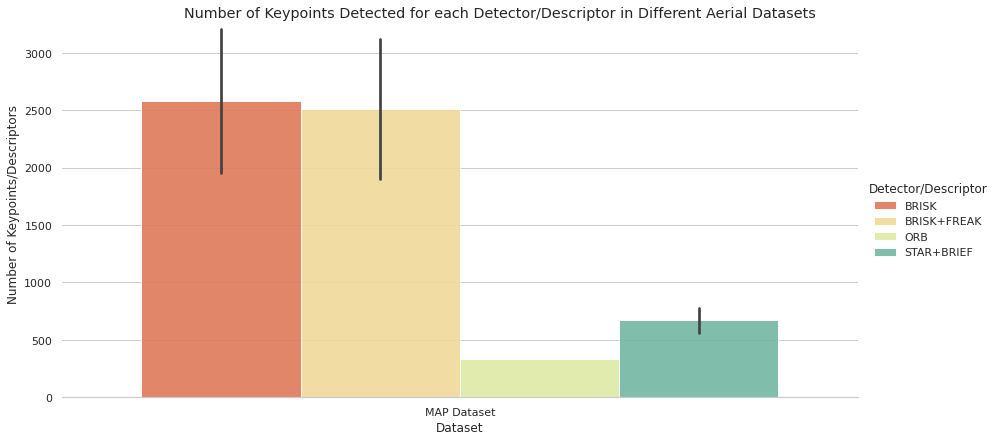

In [47]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_numkey_4, kind="bar",
    x="Dataset", y="Number of Keypoints", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=6, aspect=2
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Keypoints/Descriptors")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Keypoints Detected for each Detector/Descriptor in Different Aerial Datasets")

In [ ]:
g.savefig(f'drive/MyDrive/Num_Kypoints_6_{Dataset}.png')

In [48]:
df_numkey_4.to_csv(f'drive/MyDrive/Num_Kypoints_4_{Dataset}.csv')

In [ ]:
#print(len(num_matches_agast))

Total Number of Matches Detected for each Detector+Descriptor

In [51]:
#df_match_15['Number of Total Matches'] =  num_matches_agast + num_matches_akaze + num_matches_brisk + num_matches_daisy + num_matches_fast + num_matches_freak + num_matches_gftt + num_matches_kaze + num_matches_mser + num_matches_orb + num_matches_rootsift + num_matches_sift + num_matches_briefstar + num_matches_superpoint+ num_matches_surf+ num_matches_surfsift
d = {'Dataset': [f'{Dataset}']*(num_detectors*(len_files-1)), 'Number of Total Matches': num_matches_brisk + num_matches_freak +  num_matches_orb + num_matches_briefstar, 'Detector/Descriptor': ['BRISK']*(len_files-1) + ['BRISK+FREAK']*(len_files-1) +  ['ORB']*(len_files-1) + ['STAR+BRIEF']*(len_files-1)   }
df_match_4 = pd.DataFrame(data=d)
df_match_4['Number of Total Matches'] = df_match_4['Number of Total Matches']/(len_files-1)

Text(0.5, 0.98, 'Total Number of Matches Detected for each Detector/Descriptor in Different Aerial Datasets')

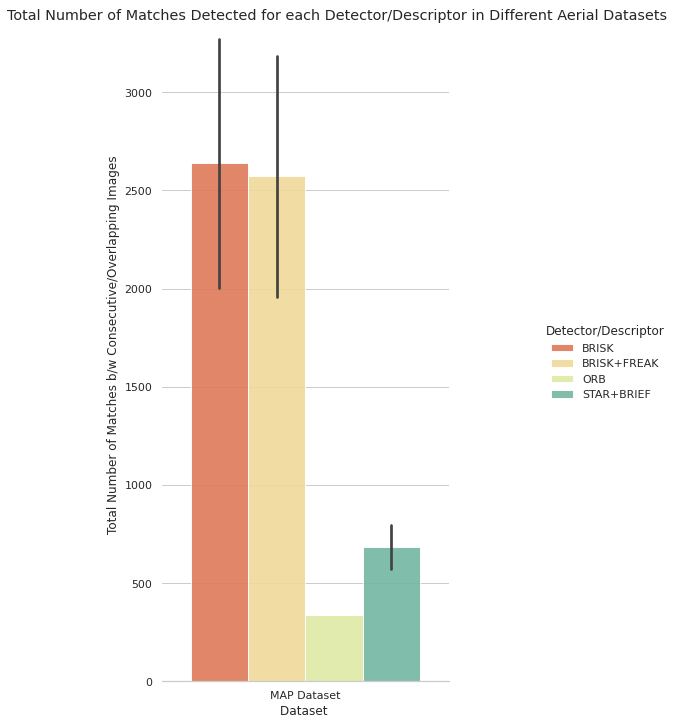

In [52]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_4, kind="bar",
    x="Dataset", y="Number of Total Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset ", "Total Number of Matches b/w Consecutive/Overlapping Images")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Total Number of Matches Detected for each Detector/Descriptor in Different Aerial Datasets")

In [ ]:
g.savefig(f'drive/MyDrive/Num_Matches_6_{Dataset}.png')

In [ ]:
#df_match_16.to_csv('drive/MyDrive/Num_Matches_16.csv')

Total Number of Good/Robust Matches (NN+Lowe+RANSAC) Detected for each Detector+Descriptor

In [53]:
df_match_4['Number of Good Matches'] = num_good_matches_brisk + num_good_matches_freak + num_good_matches_orb +  num_good_matches_briefstar
df_match_4['Number of Good Matches'] = df_match_4['Number of Good Matches']/(len_files-1)

Text(0.5, 0.98, 'Number of Good Matches (Lowe + RANSAC) Detected for each Detector/Descriptor in Different Aerial Datasets')

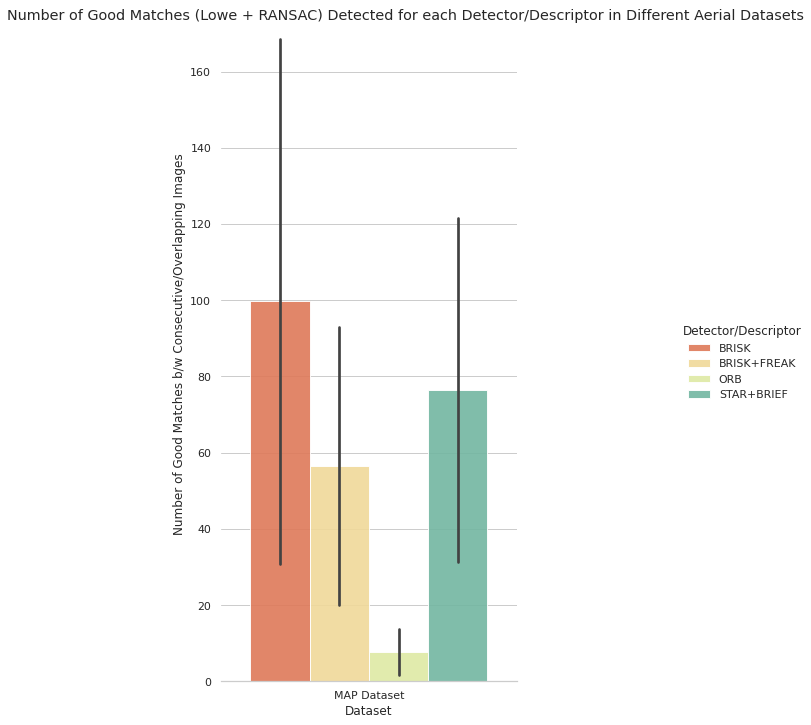

In [54]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_4, kind="bar",
    x="Dataset", y="Number of Good Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Number of Good Matches b/w Consecutive/Overlapping Images")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Number of Good Matches (Lowe + RANSAC) Detected for each Detector/Descriptor in Different Aerial Datasets")

In [ ]:
g.savefig('drive/MyDrive/Num_Good_Matches_6.png')

In [ ]:
#df_match_16.to_csv('drive/MyDrive/Num_Good_Matches_16.csv')

Recall Rate for each Detector+Descriptor

In [55]:
df_match_4['Recall Rate of Matches'] = df_match_4['Number of Good Matches']/df_match_4['Number of Total Matches']

Text(0.5, 0.98, 'Recall Rate of Matches Detected (Good/Total) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)')

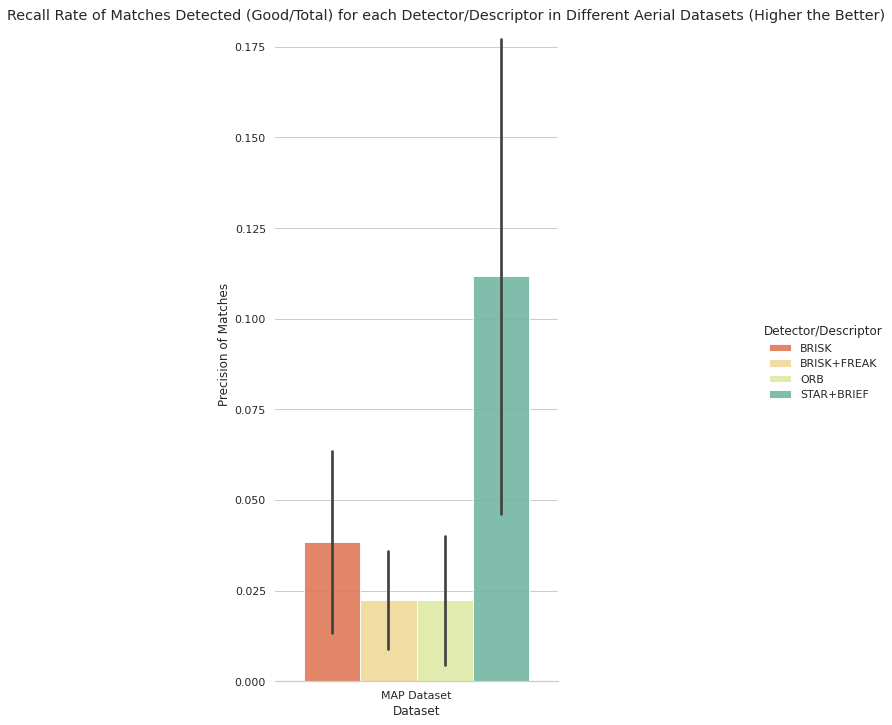

In [56]:
import seaborn as sns
sns.set_theme(style='whitegrid')


g = sns.catplot(
    data=df_match_4, kind="bar",
    x="Dataset", y="Recall Rate of Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Precision of Matches")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Recall Rate of Matches Detected (Good/Total) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)")

In [ ]:
g.savefig('drive/MyDrive/Recall_Rate_Matches_6.png')

1-Precision Rate for each Detector+Descriptor

In [57]:
df_match_4['1 - Precision Rate of Matches'] = (df_match_4['Number of Total Matches'] - df_match_4['Number of Good Matches'])/df_match_4['Number of Total Matches']

Text(0.5, 0.98, '1 - Precision rate of Matches Detected (False/Total Matches) for each Detector/Descriptor in Different Aerial Datasets (Lower the Better)')

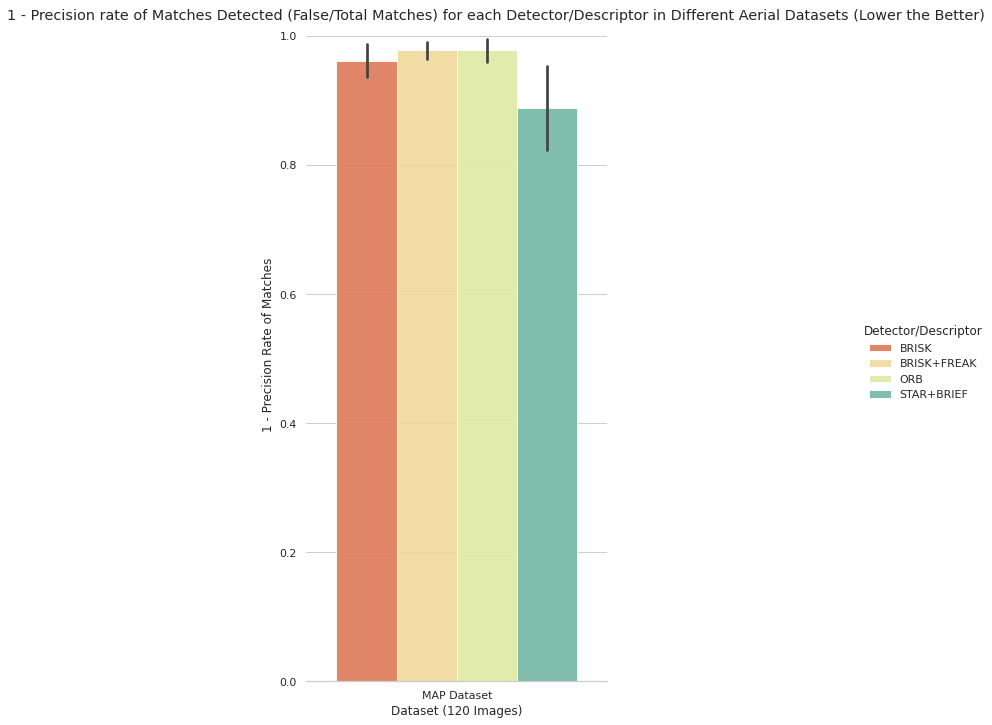

In [58]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_4, kind="bar",
    x="Dataset", y="1 - Precision Rate of Matches", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset (120 Images)", "1 - Precision Rate of Matches")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("1 - Precision rate of Matches Detected (False/Total Matches) for each Detector/Descriptor in Different Aerial Datasets (Lower the Better)")

In [ ]:
g.savefig('drive/MyDrive/One_minus_Precision_Rate_Matches_6.png')

F-Score for each Detector+Descriptor

In [59]:
df_match_4['F-Score'] = (2* (1 - df_match_4['1 - Precision Rate of Matches']) * df_match_4['Recall Rate of Matches'])/((1 - df_match_4['1 - Precision Rate of Matches']) + df_match_4['Recall Rate of Matches'])

Text(0.5, 0.98, 'F-Score of Matches Detected (2*P*R/P+R) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)')

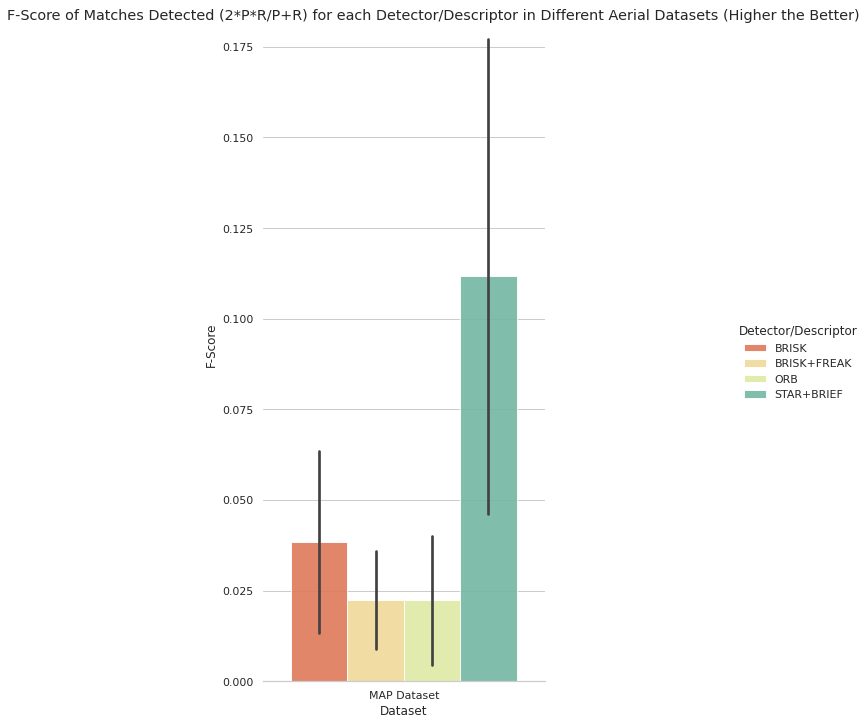

In [60]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_match_4, kind="bar",
    x="Dataset", y="F-Score", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "F-Score")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("F-Score of Matches Detected (2*P*R/P+R) for each Detector/Descriptor in Different Aerial Datasets (Higher the Better)")

In [ ]:
g.savefig('drive/MyDrive/F_Score_Rate_Matches_6.png')

In [61]:
df_match_4.to_csv('drive/MyDrive/All_metrics_4.csv')

Time for each Detector+Descriptor

In [62]:
d = {'Dataset': [f'{Dataset}']*(num_detectors), 'Time': [time_all[3]] + [time_all[0]] + [time_all[2]] + [time_all[1]], 'Detector/Descriptor': ['BRISK']*(1) + ['BRISK+FREAK']*(1) + ['ORB']*(1) + ['STAR+BRIEF']*(1) }
df_time_4 = pd.DataFrame(data=d)

In [63]:
print(df_time_4)

       Dataset        Time Detector/Descriptor
0  MAP Dataset  344.683259               BRISK
1  MAP Dataset  352.603517         BRISK+FREAK
2  MAP Dataset  205.844898                 ORB
3  MAP Dataset   55.566754          STAR+BRIEF


Text(0.5, 0.98, 'Time taken during Feature Extraction by each Detector/Descriptor in Different Aerial Datasets (Lower the Better)')

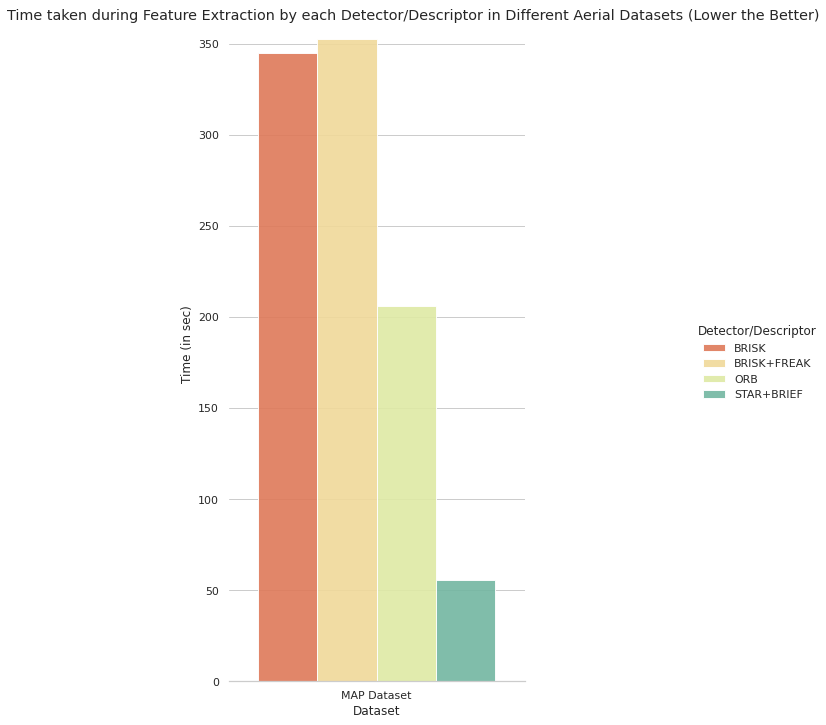

In [64]:
import seaborn as sns
sns.set_theme(style='whitegrid')


# Draw a nested barplot by species and sex
g = sns.catplot(
    data=df_time_4, kind="bar",
    x="Dataset", y="Time", hue="Detector/Descriptor",
    ci="sd", palette="Spectral", alpha=.9, height=10, aspect=0.5
)
g.despine(left=True)
g.set_axis_labels("Dataset", "Time (in sec)")
g.legend.set_title("Detector/Descriptor")
g.fig.suptitle("Time taken during Feature Extraction by each Detector/Descriptor in Different Aerial Datasets (Lower the Better)")

In [ ]:
g.savefig('drive/MyDrive/Time_6.png')

In [65]:
df_time_4.to_csv('drive/MyDrive/Time_4.csv')

Stitching with CPU